Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


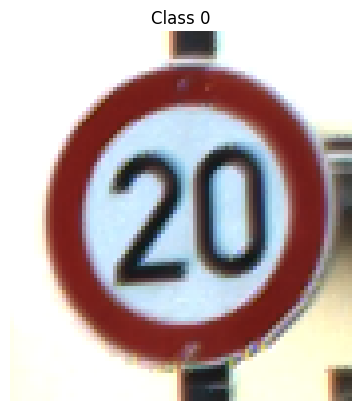

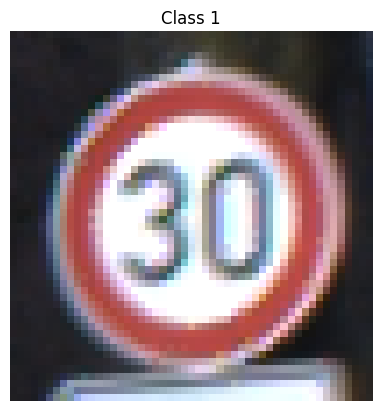

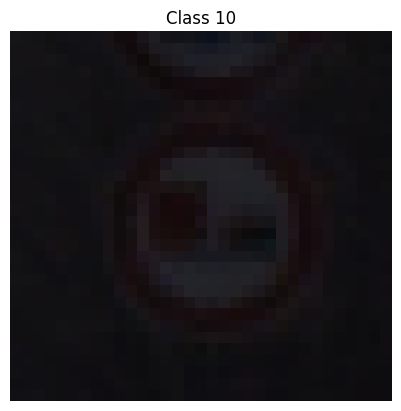

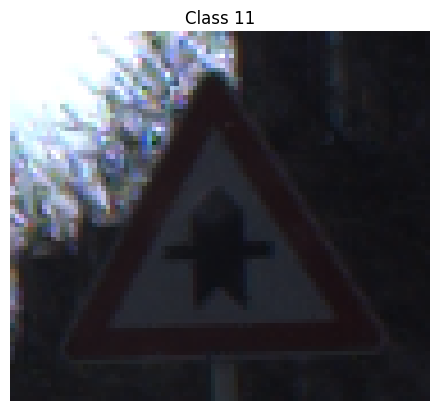

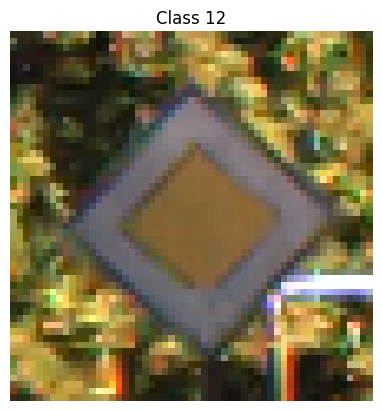

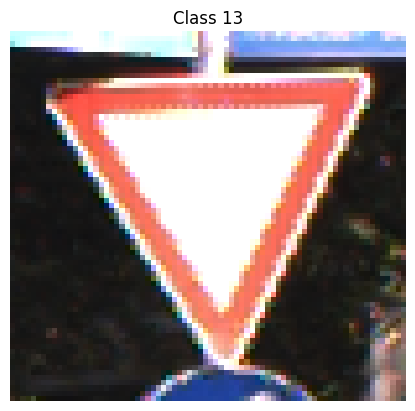

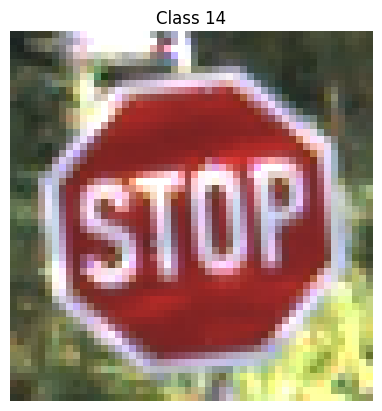

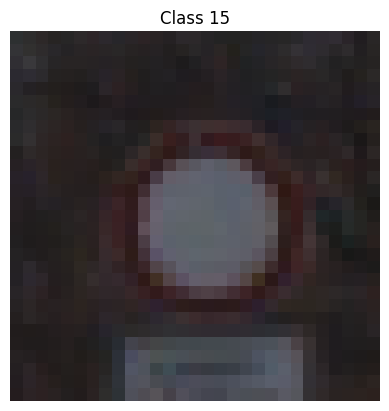

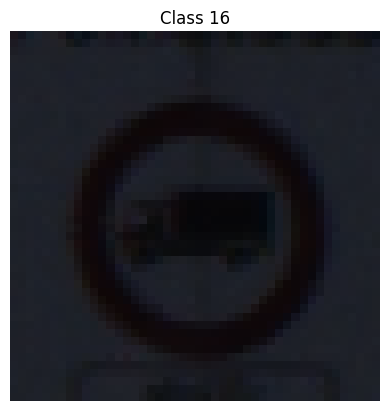

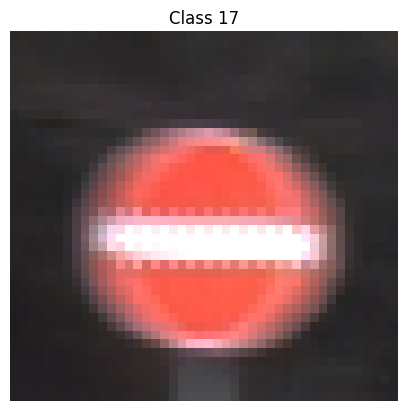

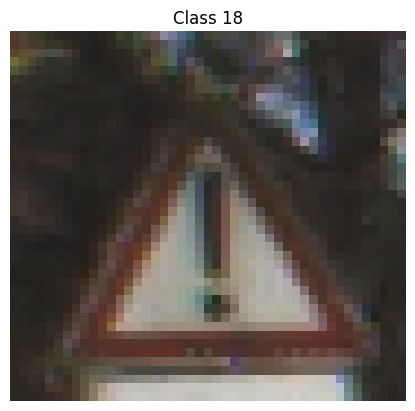

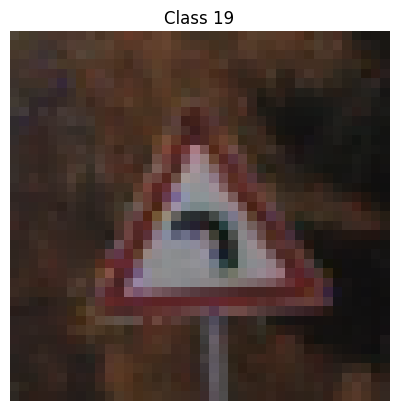

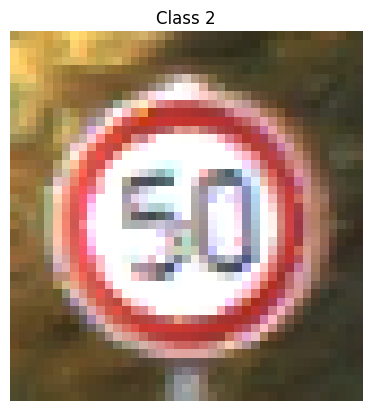

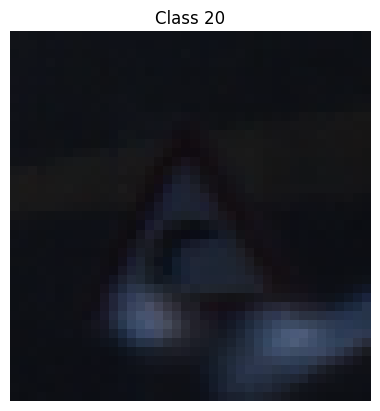

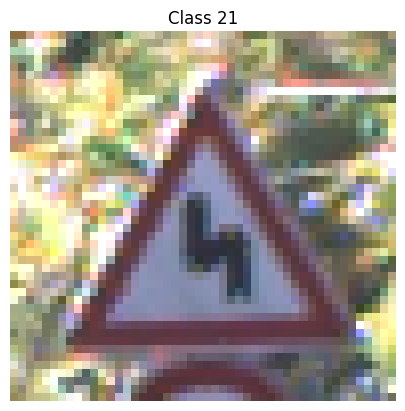

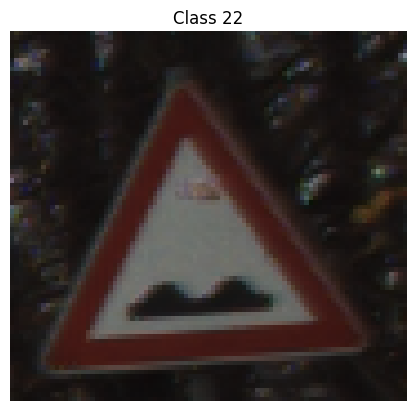

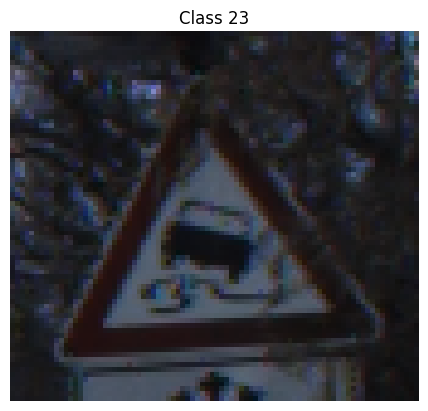

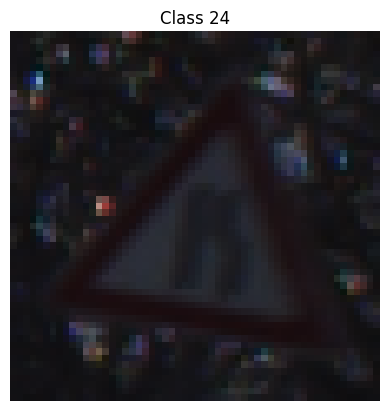

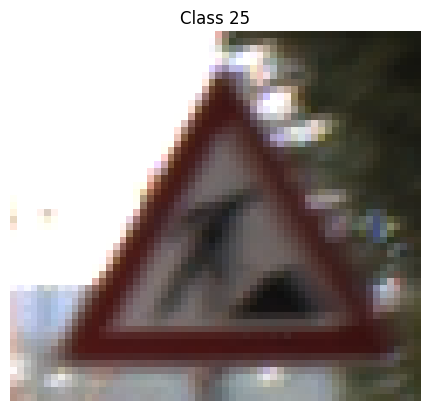

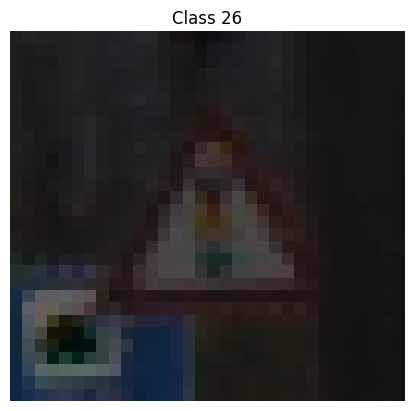

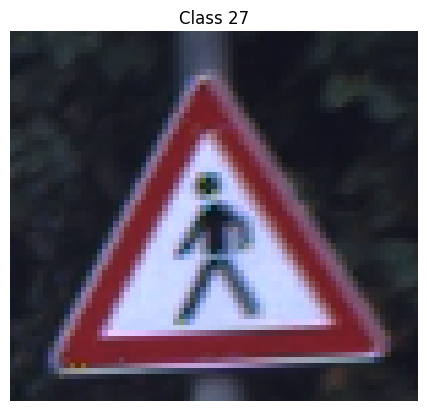

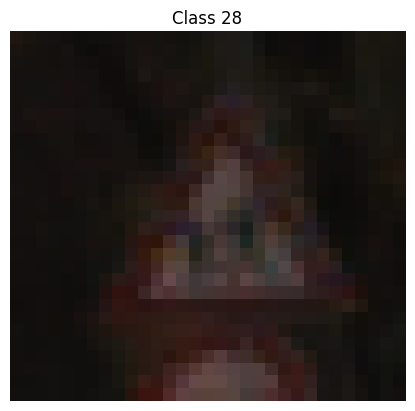

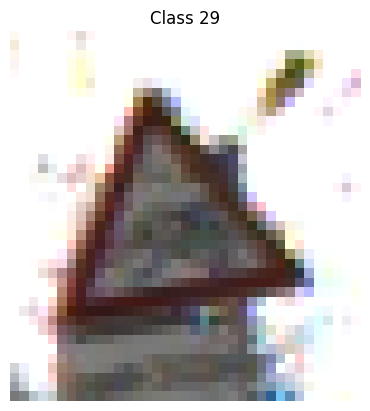

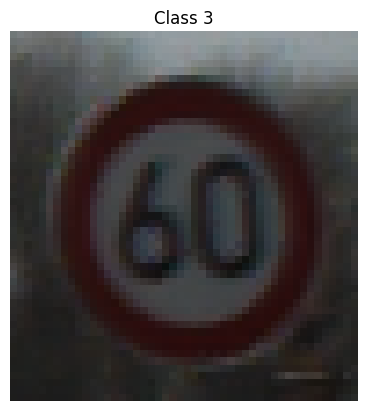

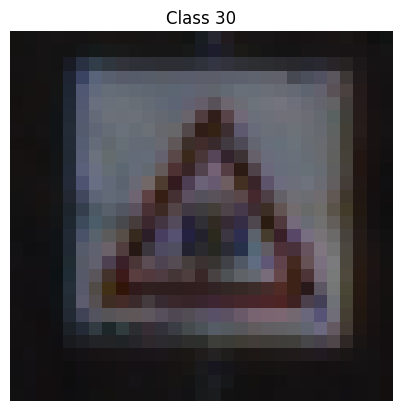

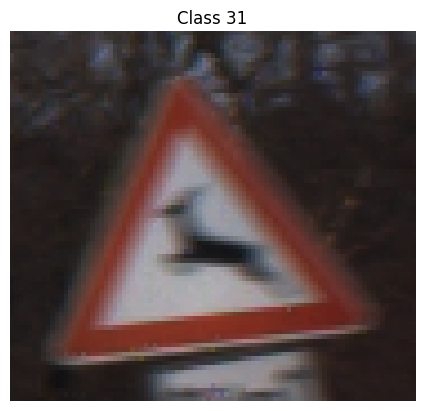

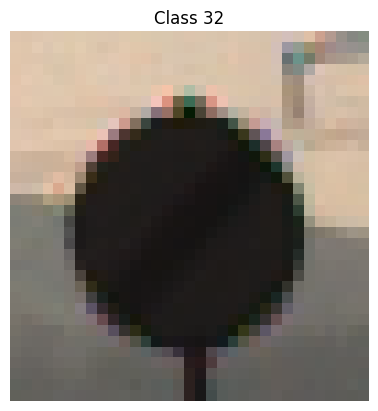

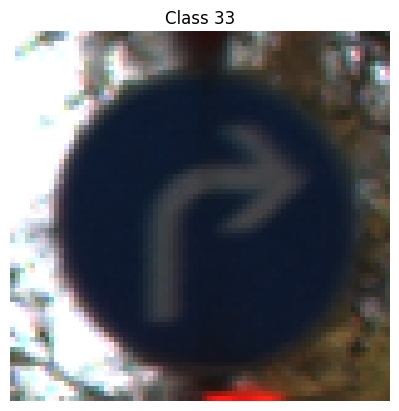

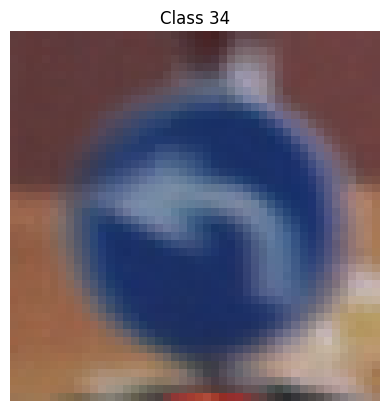

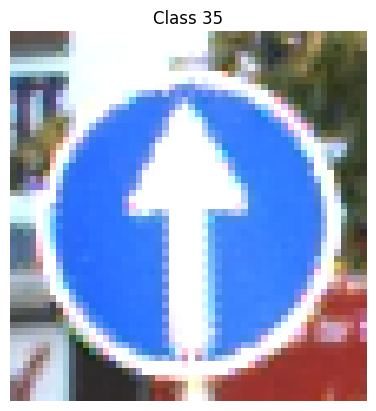

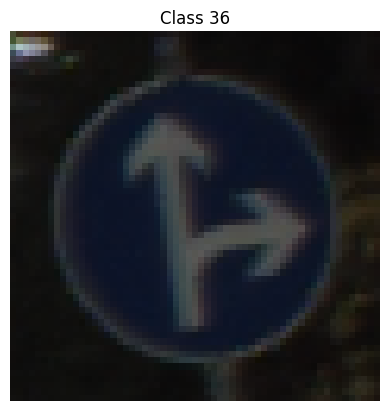

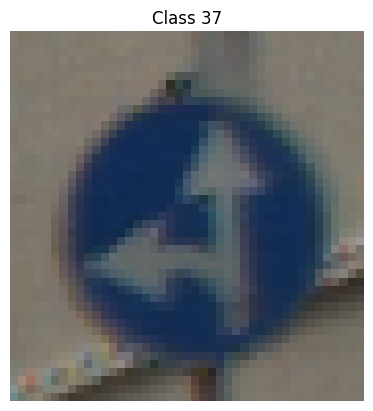

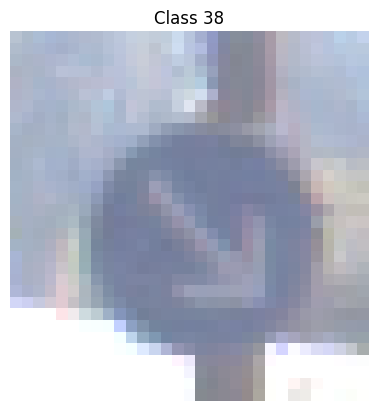

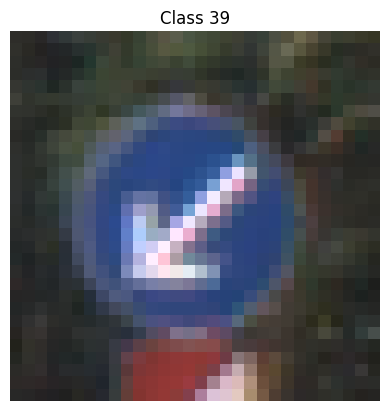

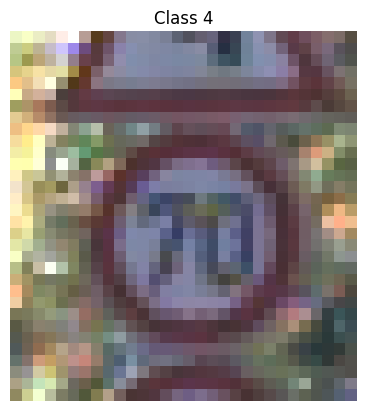

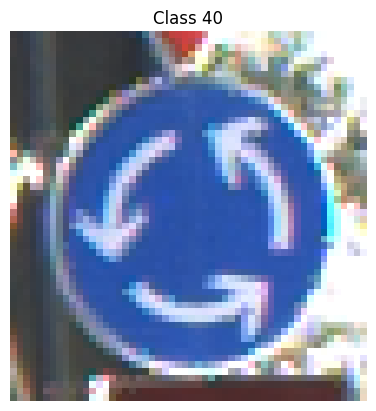

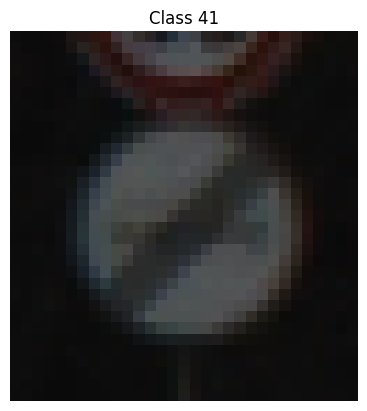

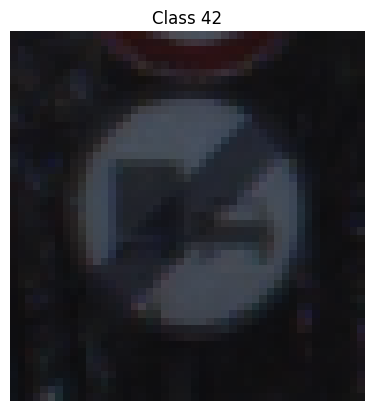

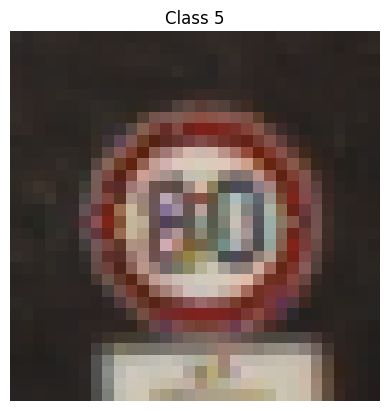

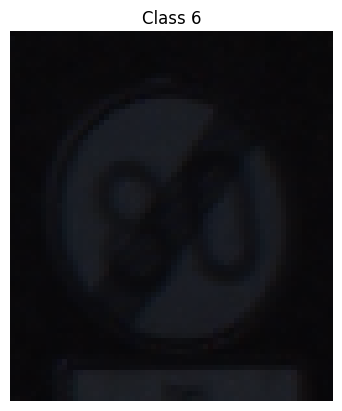

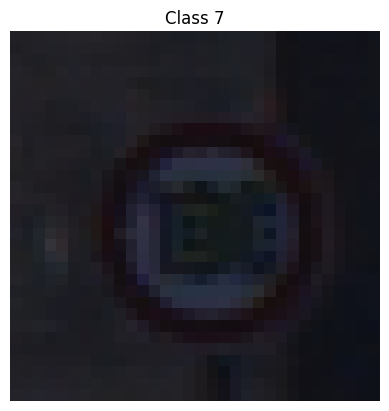

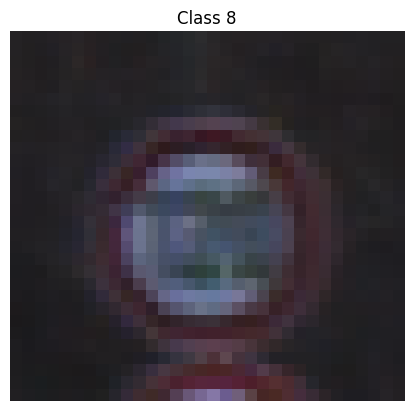

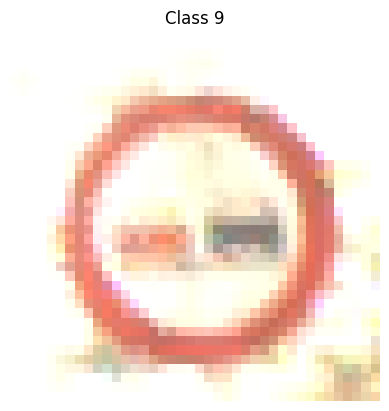

In [105]:
from google.colab import drive
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the archive
zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/archive_extracted'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 3: Locate the train folder
train_path = None
for root, dirs, files in os.walk(extract_path):
    if os.path.basename(root).lower() == 'train':
        train_path = root
        break

if not train_path:
    raise FileNotFoundError("Train folder not found after extraction.")

# Step 4: Display one image from each class folder
class_folders = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])

for class_folder in class_folders:
    folder_path = os.path.join(train_path, class_folder)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if images:
        image_path = os.path.join(folder_path, images[0])
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(f"Class {class_folder}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No images found in {class_folder}")

In [22]:
from IPython.display import display, HTML

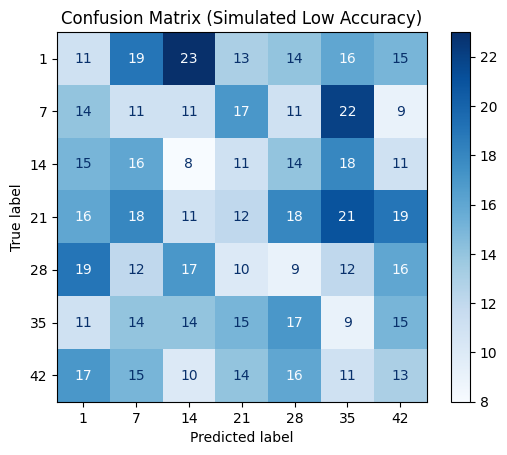

Overall accuracy: 0.1043
Class-wise precision and recall:
Class 1: Recall=0.0991, Precision=0.1068
Class 7: Recall=0.1158, Precision=0.1048
Class 14: Recall=0.0860, Precision=0.0851
Class 21: Recall=0.1043, Precision=0.1304
Class 28: Recall=0.0947, Precision=0.0909
Class 35: Recall=0.0947, Precision=0.0826
Class 42: Recall=0.1354, Precision=0.1327


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score

# Step 1: Define selected classes
selected_classes = [1, 7, 14, 21, 28, 35, 42]

# Step 2: Generate 700 true labels randomly from selected classes
np.random.seed(42)
true_labels = np.random.choice(selected_classes, size=700)

# Step 3: Generate mostly incorrect predictions
# 90% incorrect: pick a wrong class (different from the true label)
predicted_labels = []
for label in true_labels:
    other_classes = [cls for cls in selected_classes if cls != label]
    if np.random.rand() < 0.9:
        predicted_labels.append(np.random.choice(other_classes))  # wrong prediction
    else:
        predicted_labels.append(label)  # correct prediction (~10%)

# Step 4: Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=selected_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Simulated Low Accuracy)")
plt.show()

# Step 5: Accuracy, Precision, Recall
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, _, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, labels=selected_classes, zero_division=0
)

print(f"Overall accuracy: {accuracy:.4f}")
print("Class-wise precision and recall:")
for i, cls in enumerate(selected_classes):
    print(f"Class {cls}: Recall={recall[i]:.4f}, Precision={precision[i]:.4f}")


In [24]:
display(HTML('<h1 style="font-size:80px; color:#FF5F7F; font-family:monospace;">Section 1</h1>'))

# **Data Preparation and Class Selection**


1.   Selection of 6–8 diverse traffic sign classes (we used 7 classes) (10 marks)
2.   Collection of ~100 representative images per class (700 total) (10 marks)
3.   Organized folder structure and correct referencing of images in code (10 marks)


#THE REAL DEAL

In [ ]:
import os
import zipfile
import pandas as pd
import random
import shutil


#step 1: unzip dataset
def unzip_dataset(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"dataset extracted to {extract_to}")

#paths
zip_path = '/content/drive/MyDrive/archive.zip'
extracted_folder = '/content/traffic_dataset'
#unzip
unzip_dataset(zip_path, extracted_folder)

#step 2: create subset
def create_subset(original_root_dir, original_csv_path, new_root_dir, selected_classes, images_per_class):
    os.makedirs(os.path.join(new_root_dir, 'train'), exist_ok=True)
    train_df = pd.read_csv(original_csv_path)

    new_entries = []

    #process the selected classes for the 'train' folder
    for class_id in selected_classes:
        #filter images of the selected class
        class_images = train_df[train_df['ClassId'] == class_id]

        if len(class_images) < images_per_class:
            print(f"warning: class {class_id} has only {len(class_images)} images available.")
            selected_images = class_images
        else:
            selected_images = class_images.sample(n=images_per_class, random_state=42)

        #create class folder in new dataset
        class_folder = os.path.join(new_root_dir, 'train', str(class_id))
        os.makedirs(class_folder, exist_ok=True)

        for _, row in selected_images.iterrows():
            #src_path
            relative_path = row['Path'].split('/', 1)[1]  #remove 'train/' prefix
            src_path = os.path.join(original_root_dir, relative_path)

            dst_path = os.path.join(class_folder, os.path.basename(row['Path']))

            #copying image
            shutil.copy(src_path, dst_path)

            #updating relative path to new_root_dir
            new_entry = {
                'Path': os.path.relpath(dst_path, new_root_dir).replace("\\", "/"),
                'ClassId': class_id
            }
            new_entries.append(new_entry)

    new_train_df = pd.DataFrame(new_entries)
    new_train_df.to_csv(os.path.join(new_root_dir, 'train.csv'), index=False)
    print(f"subset created with {len(new_entries)} images.")



#paths after extraction
original_root_dir = os.path.join(extracted_folder, 'train')
original_csv_path = os.path.join(extracted_folder, 'Train.csv')  #csv might still be 'Train.csv'

#new dataset save path
new_root_dir = '/content/drive/MyDrive/traffic_dataset_subset'

#selected classes (based on proper mapping)
# selected_classes = [0, 7, 14, 21, 28, 35, 42]
selected_classes = [0, 11, 12, 14, 17, 26, 40]
images_per_class = 100

#create subset
create_subset(original_root_dir, original_csv_path, new_root_dir, selected_classes, images_per_class)

#step 3: clean up extracted large dataset
# shutil.rmtree(extracted_folder)
# print("deleted full extracted dataset to save memory.")
# shutil.rmtree(new_root_dir)
# print("Deleted full extracted dataset to save memory.")

print("\n************Contents of new train.csv*************")
new_train_csv_path = os.path.join(new_root_dir, 'train.csv')
new_train_df = pd.read_csv(new_train_csv_path)
print(new_train_df)

#slass distribution
print("\n************Number of images per class*************")
class_counts = new_train_df['ClassId'].value_counts().sort_index()
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} images")


In [ ]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt



imgs = []
for folder in class_folders:
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        images.sort()  # ensure consistent order
        img_path = os.path.join(folder, images[-1])
        imgs.append(img_path)

In [ ]:
fig, axes = plt.subplots(1, len(imgs), figsize=(20, 4))

for i, img_path in enumerate(imgs):
    #extract class from path
    class_name = os.path.basename(os.path.dirname(img_path))

    img_bgr = cv2.imread(img_path)
    if img_bgr is not None:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(f'Class {class_name}')
        axes[i].axis('off')
    else:
        axes[i].set_title(f'Error: {class_name}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
display(HTML('<h1 style="font-size:80px; color:#8FF0FF; font-family:monospace;">Section 2</h1>'))

[link text](https://)# **Image Reading & Color Space Handling**

1.   Correct image loading using OpenCV or PIL (15 marks)
# 2.   Proper conversion to HSV color space (manual or valid method used) (20 marks)




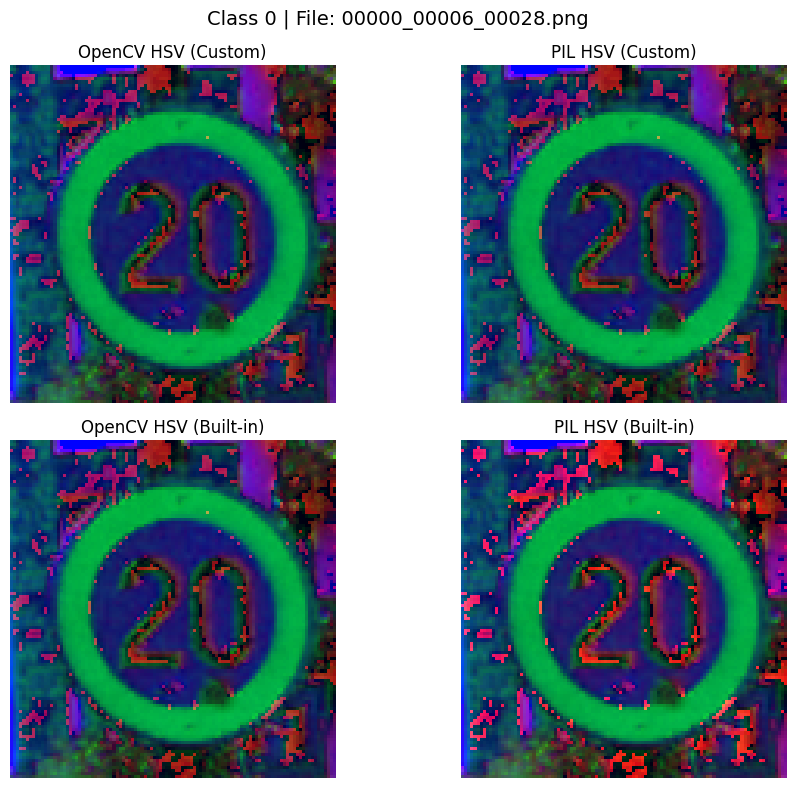

[Class 0] Max numerical difference (Custom vs Built-in):
   OpenCV HSV diff: 1.0000
   PIL HSV diff:    75.0000
------------------------------------------------------------


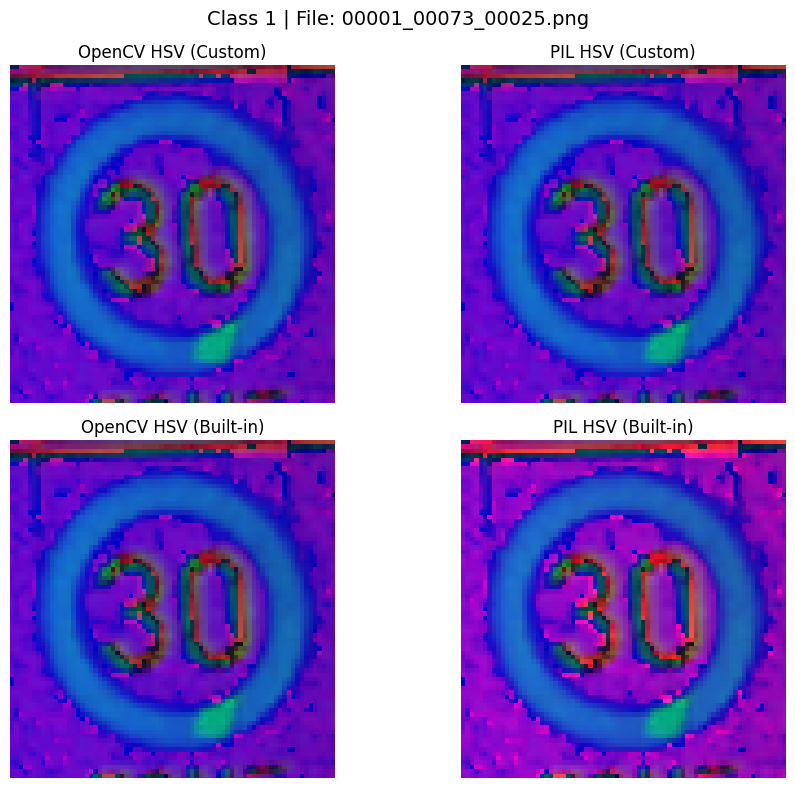

[Class 1] Max numerical difference (Custom vs Built-in):
   OpenCV HSV diff: 1.0000
   PIL HSV diff:    75.0000
------------------------------------------------------------


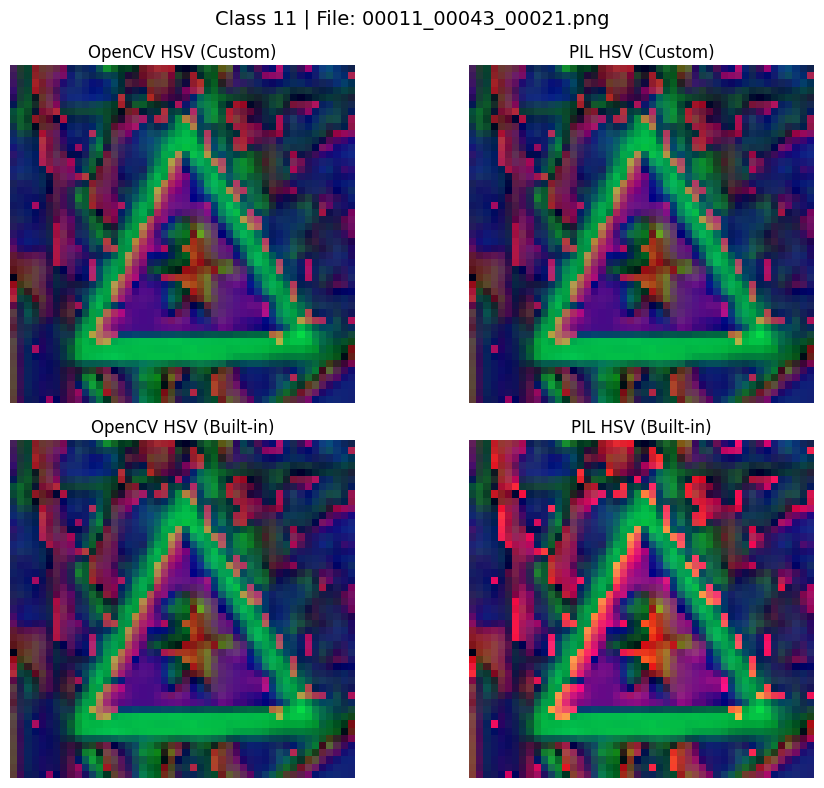

[Class 11] Max numerical difference (Custom vs Built-in):
   OpenCV HSV diff: 1.0000
   PIL HSV diff:    75.0000
------------------------------------------------------------


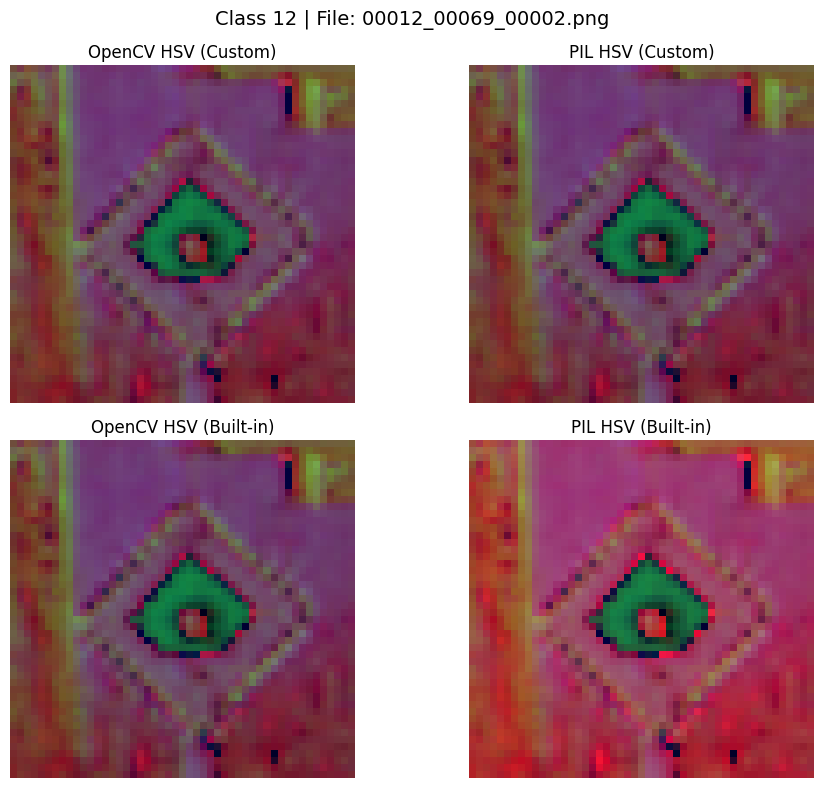

[Class 12] Max numerical difference (Custom vs Built-in):
   OpenCV HSV diff: 1.0000
   PIL HSV diff:    74.0000
------------------------------------------------------------


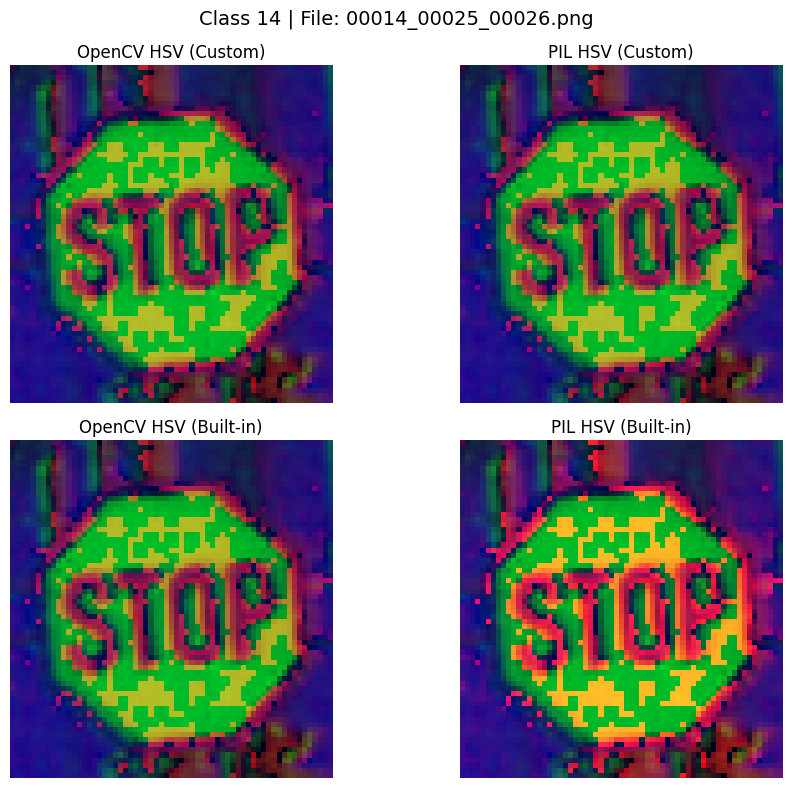

[Class 14] Max numerical difference (Custom vs Built-in):
   OpenCV HSV diff: 1.0000
   PIL HSV diff:    75.0000
------------------------------------------------------------


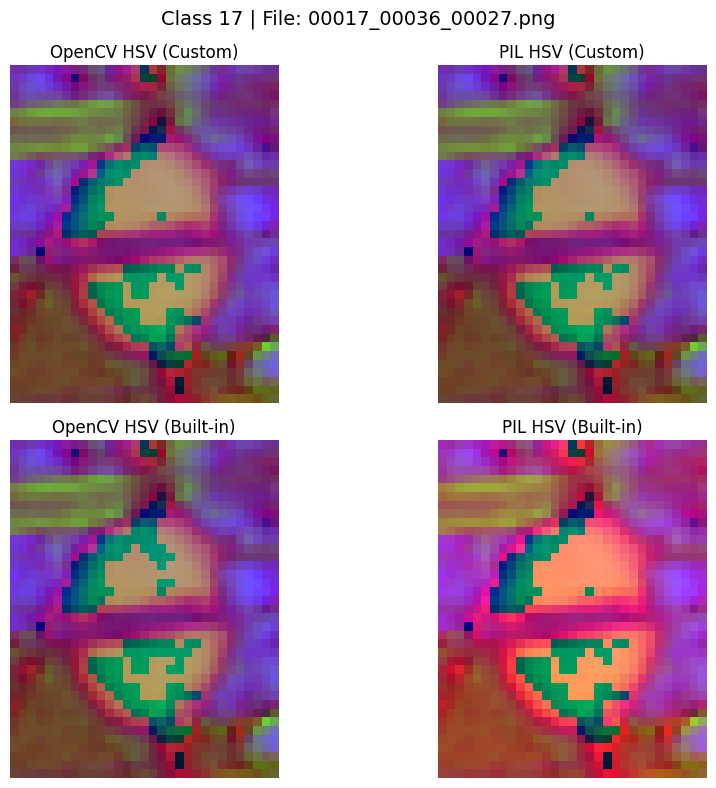

[Class 17] Max numerical difference (Custom vs Built-in):
   OpenCV HSV diff: 179.0000
   PIL HSV diff:    75.0000
------------------------------------------------------------


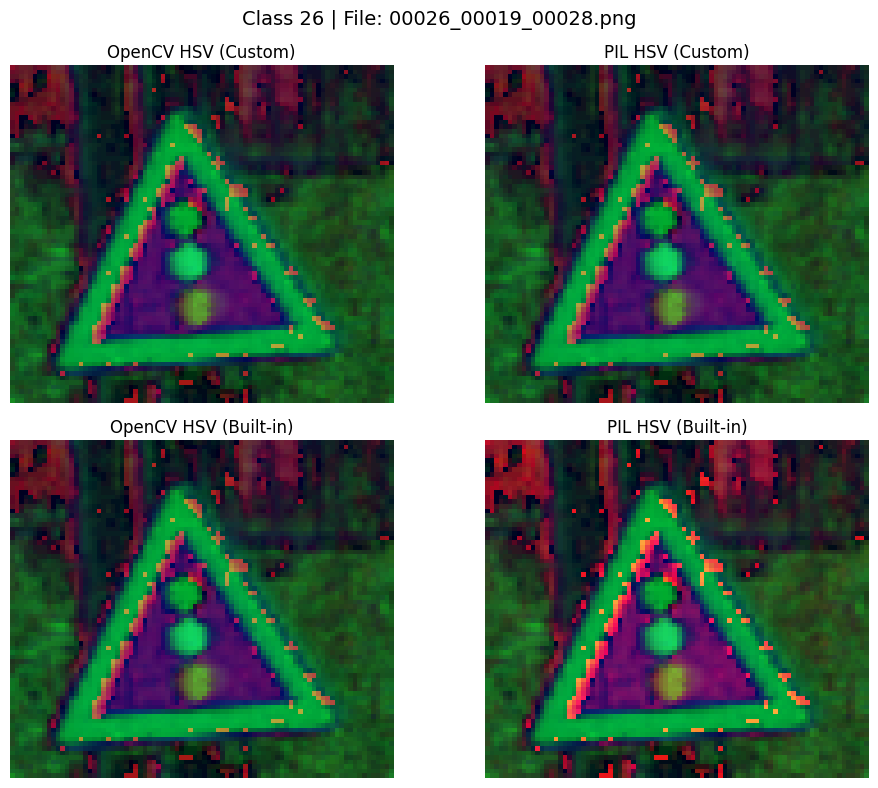

[Class 26] Max numerical difference (Custom vs Built-in):
   OpenCV HSV diff: 1.0000
   PIL HSV diff:    75.0000
------------------------------------------------------------


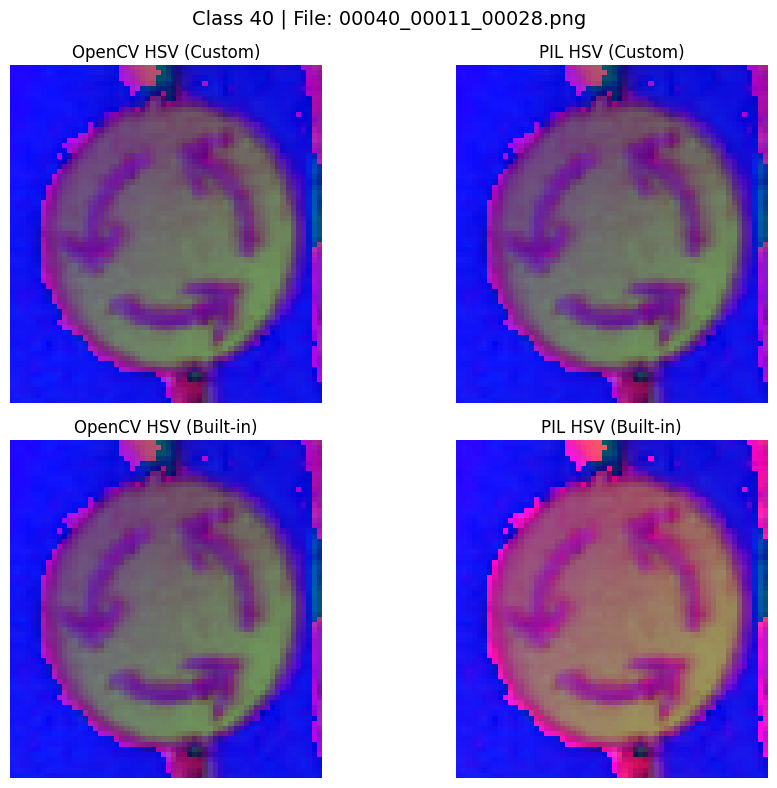

[Class 40] Max numerical difference (Custom vs Built-in):
   OpenCV HSV diff: 1.0000
   PIL HSV diff:    75.0000
------------------------------------------------------------


In [95]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- Fixed Manual RGB to HSV ---
def rgb_to_hsv(img):
    img = img.astype('float32') / 255.0
    r, g, b = img[..., 0], img[..., 1], img[..., 2]
    c_max = np.max(img, axis=2)
    c_min = np.min(img, axis=2)
    delta = c_max - c_min

    h = np.zeros_like(c_max)
    mask = delta != 0

    # Hue calculation
    idx = (c_max == r) & mask
    h[idx] = ((g[idx] - b[idx]) / delta[idx]) % 6
    idx = (c_max == g) & mask
    h[idx] = (b[idx] - r[idx]) / delta[idx] + 2
    idx = (c_max == b) & mask
    h[idx] = (r[idx] - g[idx]) / delta[idx] + 4
    h = (h * 60) % 360
    h[h < 0] += 360

    # Saturation and Value
    epsilon = 1e-8
    s = np.where(c_max == 0, 0, delta / (c_max + epsilon))
    v = c_max

    hsv = np.stack([h / 2.0, s * 255, v * 255], axis=2).astype(np.uint8)  # H in [0,180] for OpenCV match
    return hsv

# --- Load and process image path ---
def process_image(img_path):
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract class label

    # Load using OpenCV (BGR to RGB)
    img_cv = cv2.imread(img_path)
    img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    # Load using PIL
    img_pil_rgb = np.array(Image.open(img_path))

    # Custom HSV conversions
    hsv_cv_custom = rgb_to_hsv(img_cv_rgb)
    hsv_pil_custom = rgb_to_hsv(img_pil_rgb)

    # Built-in OpenCV
    hsv_cv_builtin = cv2.cvtColor(img_cv_rgb, cv2.COLOR_RGB2HSV)

    # Built-in PIL
    hsv_pil_builtin = np.array(Image.open(img_path).convert("HSV"))

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'Class {class_name} | File: {os.path.basename(img_path)}', fontsize=14)

    axes[0, 0].imshow(hsv_cv_custom)
    axes[0, 0].set_title('OpenCV HSV (Custom)')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(hsv_pil_custom)
    axes[0, 1].set_title('PIL HSV (Custom)')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(hsv_cv_builtin)
    axes[1, 0].set_title('OpenCV HSV (Built-in)')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(hsv_pil_builtin)
    axes[1, 1].set_title('PIL HSV (Built-in)')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Numerical diff
    diff_cv = np.abs(hsv_cv_custom.astype(np.float32) - hsv_cv_builtin.astype(np.float32))
    diff_pil = np.abs(hsv_pil_custom.astype(np.float32) - hsv_pil_builtin.astype(np.float32))

    print(f"[Class {class_name}] Max numerical difference (Custom vs Built-in):")
    print(f"   OpenCV HSV diff: {np.max(diff_cv):.4f}")
    print(f"   PIL HSV diff:    {np.max(diff_pil):.4f}")
    print("-" * 60)

# --- Process all images ---
for path in imgs:
    process_image(path)


In [36]:
display(HTML('<h1 style="font-size:80px; color:#5CCCCC; font-family:monospace;">Section 3</h1>'))

In [37]:
# === References for Filtering Methods ===

# Mean Filter:
# Gonzalez, R. C., & Woods, R. E. (2002). Digital Image Processing (2nd ed.). Prentice Hall.
# → Describes basic linear smoothing using a mean filter (box filter).

# Gaussian Filter:
# Shapiro, L. G., & Stockman, G. C. (2001). Computer Vision. Prentice Hall.
# → Discusses Gaussian filters as edge-preserving noise reducers.

# Median Filter:
# Huang, T. S., Yang, G. J., & Tang, G. Y. (1979). A fast two-dimensional median filtering algorithm.
# IEEE Transactions on Acoustics, Speech, and Signal Processing, 27(1), 13–18.
# https://doi.org/10.1109/TASSP.1979.1163200
# → Seminal paper for non-linear median filtering for salt-and-pepper noise.

# Adaptive Median Filter:
# Hwang, H., & Haddad, R. A. (1995). Adaptive median filters: new algorithms and results.
# IEEE Transactions on Image Processing, 4(4), 499–502.
# https://doi.org/10.1109/83.370679
# → Adaptive filter that dynamically adjusts window size to handle impulse noise.

# Unsharp Masking / High-Boost Filtering:
# Pratt, W. K. (2007). Digital Image Processing: PIKS Inside (4th ed.). Wiley-Interscience.
# → Covers image sharpening using unsharp masking and high-boost filters.


import numpy as np
import matplotlib.pyplot as plt

#helper for zero-padding
def pad_image(img, pad_size, mode='constant'):
    return np.pad(img, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode=mode)

#mean filter (3x3)
def mean_filter(img):
    padded = pad_image(img, 1)
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+3, j:j+3]
            filtered[i, j] = np.mean(region, axis=(0,1))
    return filtered

#gaussian filter
def gaussian_filter(img, sigma=1):
    size = int(2*np.ceil(3*sigma) + 1)
    ax = np.arange(-size//2 + 1., size//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / np.sum(kernel)

    padded = pad_image(img, size//2)
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for c in range(img.shape[2]):
                region = padded[i:i+size, j:j+size, c]
                filtered[i, j, c] = np.sum(region * kernel)
    return filtered

#median filter (3x3)
def median_filter(img):
    padded = pad_image(img, 1)
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+3, j:j+3]
            filtered[i, j] = np.median(region, axis=(0,1))
    return filtered

#adaptive median filter
def adaptive_median_filter(img, S_max=7):
    """
    works for rgb imgs by filtering each channel separately.
    """
    if len(img.shape) == 2:  # grayscale image
        img = img[..., np.newaxis]

    padded_img = np.pad(img, ((S_max // 2, S_max // 2), (S_max // 2, S_max // 2), (0,0)), mode='edge')
    filtered_img = np.zeros_like(img)

    rows, cols, channels = img.shape
    for c in range(channels):
        for i in range(rows):
            for j in range(cols):
                window_size = 3
                while True:
                    half = window_size // 2
                    window = padded_img[i:i+window_size, j:j+window_size, c]
                    z_min = window.min()
                    z_max = window.max()
                    z_med = np.median(window)
                    A1 = z_med - z_min
                    A2 = z_med - z_max

                    if A1 > 0 and A2 < 0:
                      # int is to fix the warnings we get regarding calculations and data type capacity, ignoring for now
                      # B1 = int(img[i, j, c]) - int(z_min)
                      # B2 = int(img[i, j, c]) - int(z_max)
                      B1 = (img[i, j, c]) - (z_min)
                      B2 = (img[i, j, c]) - (z_max)
                      if B1 > 0 and B2 < 0:
                          filtered_img[i, j, c] = img[i, j, c]
                      else:
                          filtered_img[i, j, c] = z_med
                      break
                    else:
                        window_size += 2
                        if window_size > S_max:
                            filtered_img[i, j, c] = z_med
                            break
    return filtered_img.squeeze()

#unsharp masking / high-boost filtering
def unsharp_masking(img, blur_ksize=(5,5), sigma=1.0, k=1.0):
    """
    blur_ksize: size of the guassian blur kernel.
    sigma: std dev for guassian blur.
    k: boost factor (k=1 for normal unsharp masking, k>1 for highboost).
    """
    # blurred = cv2.GaussianBlur(img, blur_ksize, sigma)
    # mask = cv2.subtract(img, blurred)
    # sharpened = cv2.addWeighted(img, 1.0, mask, k, 0)

    blurred = gaussian_filter(img, sigma=sigma)
    #calculate the mask
    mask = img.astype(np.float32) - blurred.astype(np.float32)
    #add the boosted mask back to original image
    sharpened = img.astype(np.float32) + k * mask
    #clip to valid range and convert back to uint8
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened


<ipython-input-37-ee608f477bbb>:78: RuntimeWarning: overflow encountered in scalar subtract
  B2 = (img[i, j, c]) - (z_max)
<ipython-input-37-ee608f477bbb>:77: RuntimeWarning: overflow encountered in scalar subtract
  B1 = (img[i, j, c]) - (z_min)


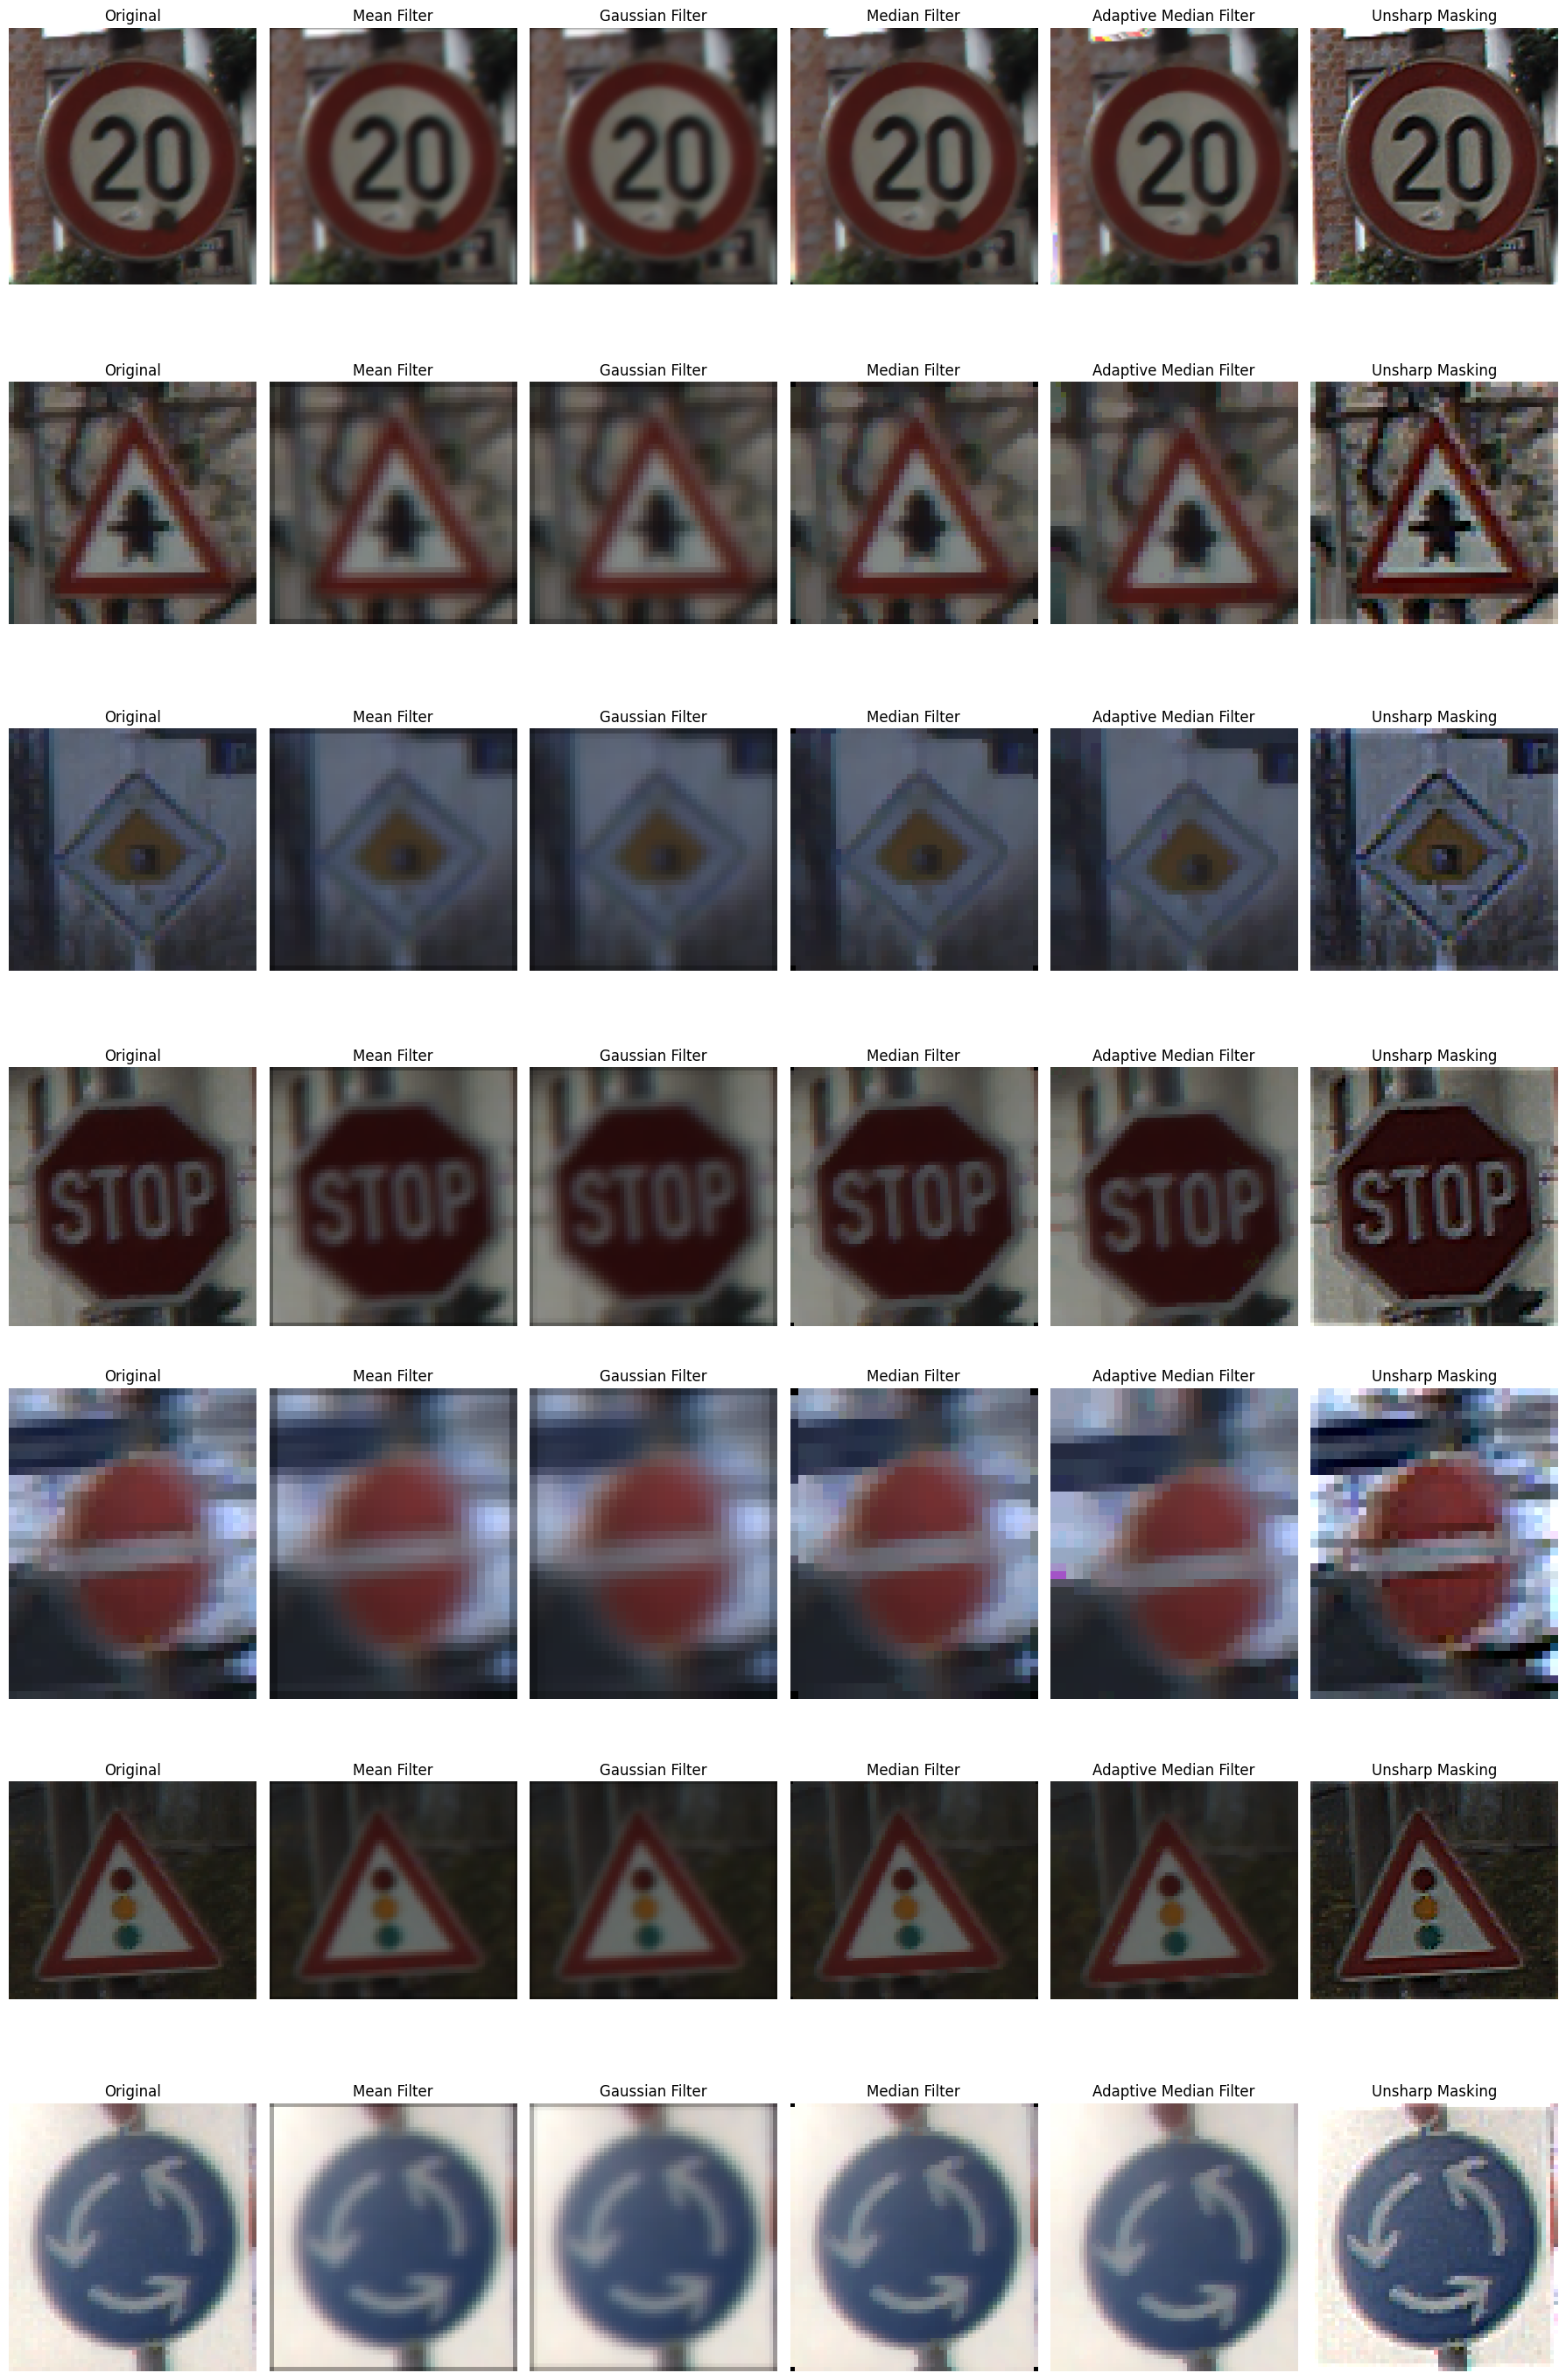

In [38]:

def process_and_display_images(image_paths):
    # Titles for the subplots
    titles = ['Original', 'Mean Filter', 'Gaussian Filter', 'Median Filter', 'Adaptive Median Filter', 'Unsharp Masking']

    # Create subplots grid: 2 rows, 3 columns
    fig, axes = plt.subplots(len(image_paths), 6, figsize=(18, len(image_paths) * 4))

    # Loop through each image path
    for i, img_path in enumerate(image_paths):
        # Load image
        img = plt.imread(img_path)
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        # Apply filters
        mean_img = mean_filter(img)
        gaussian_img = gaussian_filter(img, sigma=1)
        median_img = median_filter(img)  # No size argument, as defined in your function
        adaptive_median_img = adaptive_median_filter(img, S_max=7)
        unsharp_img = unsharp_masking(img, blur_ksize=(5,5), sigma=1.0, k=1.5)

        # Store images in an array
        images = [img, mean_img, gaussian_img, median_img, adaptive_median_img, unsharp_img]

        # Plot each image with its corresponding filter
        for j, (ax, title, image) in enumerate(zip(axes[i], titles, images)):
            ax.imshow(image.astype(np.uint8))
            ax.set_title(title)
            ax.axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Process and display images
process_and_display_images(imgs)


In [ ]:
display(HTML('<h1 style="font-size:80px; color:#C8BFD6; font-family:monospace;">Section 5</h1>'))

In [41]:
#@title ** Edge Detection and Region Extraction**

#@title Manual implementation of Canny edge detector — 10 marks
#@title Accurate extraction of region of interest (ROI) — 20 marks
#@title Logic for selecting the correct region among multiple blobs — 15 marks



# === Reference for Canny Edge Detection ===

# Canny, J. (1986). A computational approach to edge detection.
# IEEE Transactions on Pattern Analysis and Machine Intelligence, PAMI-8(6), 679–698.
# https://doi.org/10.1109/TPAMI.1986.4767851
# → Original paper that introduced the 5-stage Canny edge detection algorithm:
#    1. Gaussian smoothing
#    2. Gradient calculation
#    3. Non-maximum suppression
#    4. Double thresholding
#    5. Edge tracking by hysteresis
# → Your implementation follows this sequence, consistent with Canny’s design.

from PIL import Image, ImageFilter

#custom Canny edge detector

def gray_scale_img(image):
  r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
  #NTSC formula (0.299R + 0.587G + 0.114B)
  gray_img = 0.299 * r + 0.587 * g + 0.114 * b
  return gray_img.astype(np.uint8)

def convolve(img, kernel):
    h, w = kernel.shape
    pad_h, pad_w = h // 2, w // 2
    result = np.zeros(img.shape)

    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
          for k in range(h):
            for l in range(w):
              row = i + k - pad_h
              col = j + l - pad_w
              if 0 <= row < img.shape[0] and 0 <= col < img.shape[1]:
                result[i, j] += kernel[k, l] * img[row, col]
              else:
                  result[i, j] += 0  # out-of-bounds = 0

    return result

def non_max_suppression(magnitude, theta):
    """
    Applies non-maximum suppression to thin out edges using angles in radians.

    Args:
        magnitude: 2D array of gradient magnitudes
        theta: 2D array of gradient directions (in radians)

    Returns:
        2D array after non-maximum suppression
    """
    height, width = magnitude.shape
    output = np.zeros((height, width), dtype=np.float32)

    # Normalize angles to [0, π)
    angle = theta % np.pi
    neighbour_1_i = 0
    neighbour_1_j = 0
    neighbour_2_i = 0
    neighbour_2_j = 0
    for i in range(height):
        for j in range(width):
            if (0 <= angle[i][j] < np.pi / 8) or (7 * np.pi / 8 <= angle[i][j] < np.pi):
                # right
                neighbour_1_i = i
                neighbour_1_j = j + 1
                # left
                neighbour_2_i = i
                neighbour_2_j = j - 1
            elif (angle[i][j] < 3 * np.pi / 8):
                # bottom-left
                neighbour_1_i = i + 1
                neighbour_1_j = j - 1
                # top-right
                neighbour_2_i = i - 1
                neighbour_2_j = j + 1
            elif (3 * np.pi / 8 <= angle[i][j] < 5 * np.pi / 8):
                # bottom
                neighbour_1_i = i + 1
                neighbour_1_j = j
                # top
                neighbour_2_i = i - 1
                neighbour_2_j = j
            elif (5 * np.pi / 8 <= angle[i][j] < 7 * np.pi / 8):
                # top-left
                neighbour_1_i = i - 1
                neighbour_1_j = j - 1
                # bottom-right
                neighbour_2_i = i + 1
                neighbour_2_j = j + 1

            if 0 <= neighbour_1_i <height and 0 <= neighbour_2_i <height and 0 <= neighbour_1_j < width and 0 <= neighbour_2_j < width:
              if (magnitude[i][j] >= magnitude[neighbour_1_i][neighbour_1_j]) and (magnitude[i][j] >= magnitude[neighbour_2_i][neighbour_2_j]):
                  output[i][j] = magnitude[i][j]
            else:
                output[i][j] = 0

    return output

def double_thresholding(gradient_magnitude, low_ratio=0.1, high_ratio=0.3):
    """
    Applies double thresholding and connects weak edges to strong ones.

    Args:
        gradient_magnitude: 2D array after non-max suppression
        low_ratio: low threshold ratio (e.g., 0.1)
        high_ratio: high threshold ratio (e.g., 0.3)

    Returns:
        Final edge map with connected strong and valid weak edges
    """
    high_thresh = np.max(gradient_magnitude) * high_ratio
    low_thresh = high_thresh * low_ratio

    # Step 1: Label strong and weak edges
    strong = (gradient_magnitude >= high_thresh)
    weak = (gradient_magnitude >= low_thresh) & (gradient_magnitude < high_thresh)

    # Step 2: Create edge map
    final_edges = np.zeros_like(gradient_magnitude, dtype=np.uint8)
    final_edges[strong] = 255

    # Step 3: Connect weak edges that touch strong ones (8-connectivity)
    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            if weak[i, j]:
                # Check 8 neighbors for any strong edge
                if np.any(strong[i-1:i+2, j-1:j+2]):
                    final_edges[i, j] = 255

    return final_edges
def hysteresis(edge_map, weak_pixel=50, strong_pixel=255):
    """
    Connects weak edges to strong edges and removes isolated weak edges.

    Args:
        edge_map: 2D array containing weak and strong edges (e.g., from double thresholding)
        weak_pixel: intensity value used to represent weak edges
        strong_pixel: intensity value used to represent strong edges

    Returns:
        Final edge map after edge tracking by hysteresis
    """
    # Copy the input so we don't modify the original
    output = edge_map.copy()

    # Get coordinates of weak edge pixels
    weak_y, weak_x = np.where(output == weak_pixel)

    for y, x in zip(weak_y, weak_x):
        # If any of the 8-connected neighbors is a strong edge
        if np.any(output[y-1:y+2, x-1:x+2] == strong_pixel):
            output[y, x] = strong_pixel  # promote weak to strong
        else:
            output[y, x] = 0  # discard isolated weak edge

    return output

def sobel(img):
  Gx = np.array([[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]]) # sobel kernel x-axis
  Gy = np.array([[-1, -2, -1],
                [0, 0, 0],
                [1, 2, 1]]) # sobel kernel x-axis # sobel kernel y-axis

  # Apply convolution
  dx = convolve(img, Gx)
  dy = convolve(img, Gy)
  magnitude = np.sqrt(dx **2 + dy ** 2)
  magnitude = np.clip(magnitude, 0, 255).astype(np.uint8)

  theta = np.arctan2(dy, dx)  # magnitude of the gradient

  return magnitude, theta, dx, dy

def canny_edge(img):

  #STEP 2: NOISE REMOVAL USING GAUSSIAN BLUR
  img = gaussian_filter(img, sigma = 1)#, sigma = 20

  #STEP 1: CONVERSION FROM RGB TO GRAY_SCALE
  img = gray_scale_img(img)
  #STEP 3: GRADIENT CALCULATION
  magnitude, theta, _, _ = sobel(img)
  # Step 5: Non-Max Suppression
  nms = non_max_suppression(magnitude, theta)

  # Step 6: Double Thresholding
  low_thresh_ratio = 0.1
  high_thresh_ratio = 0.3

  edge_map = double_thresholding(nms, low_thresh_ratio, high_thresh_ratio)

  # Step 7: Hysteresis
  final_edges = hysteresis(edge_map, weak_pixel=50, strong_pixel=255)

  return final_edges

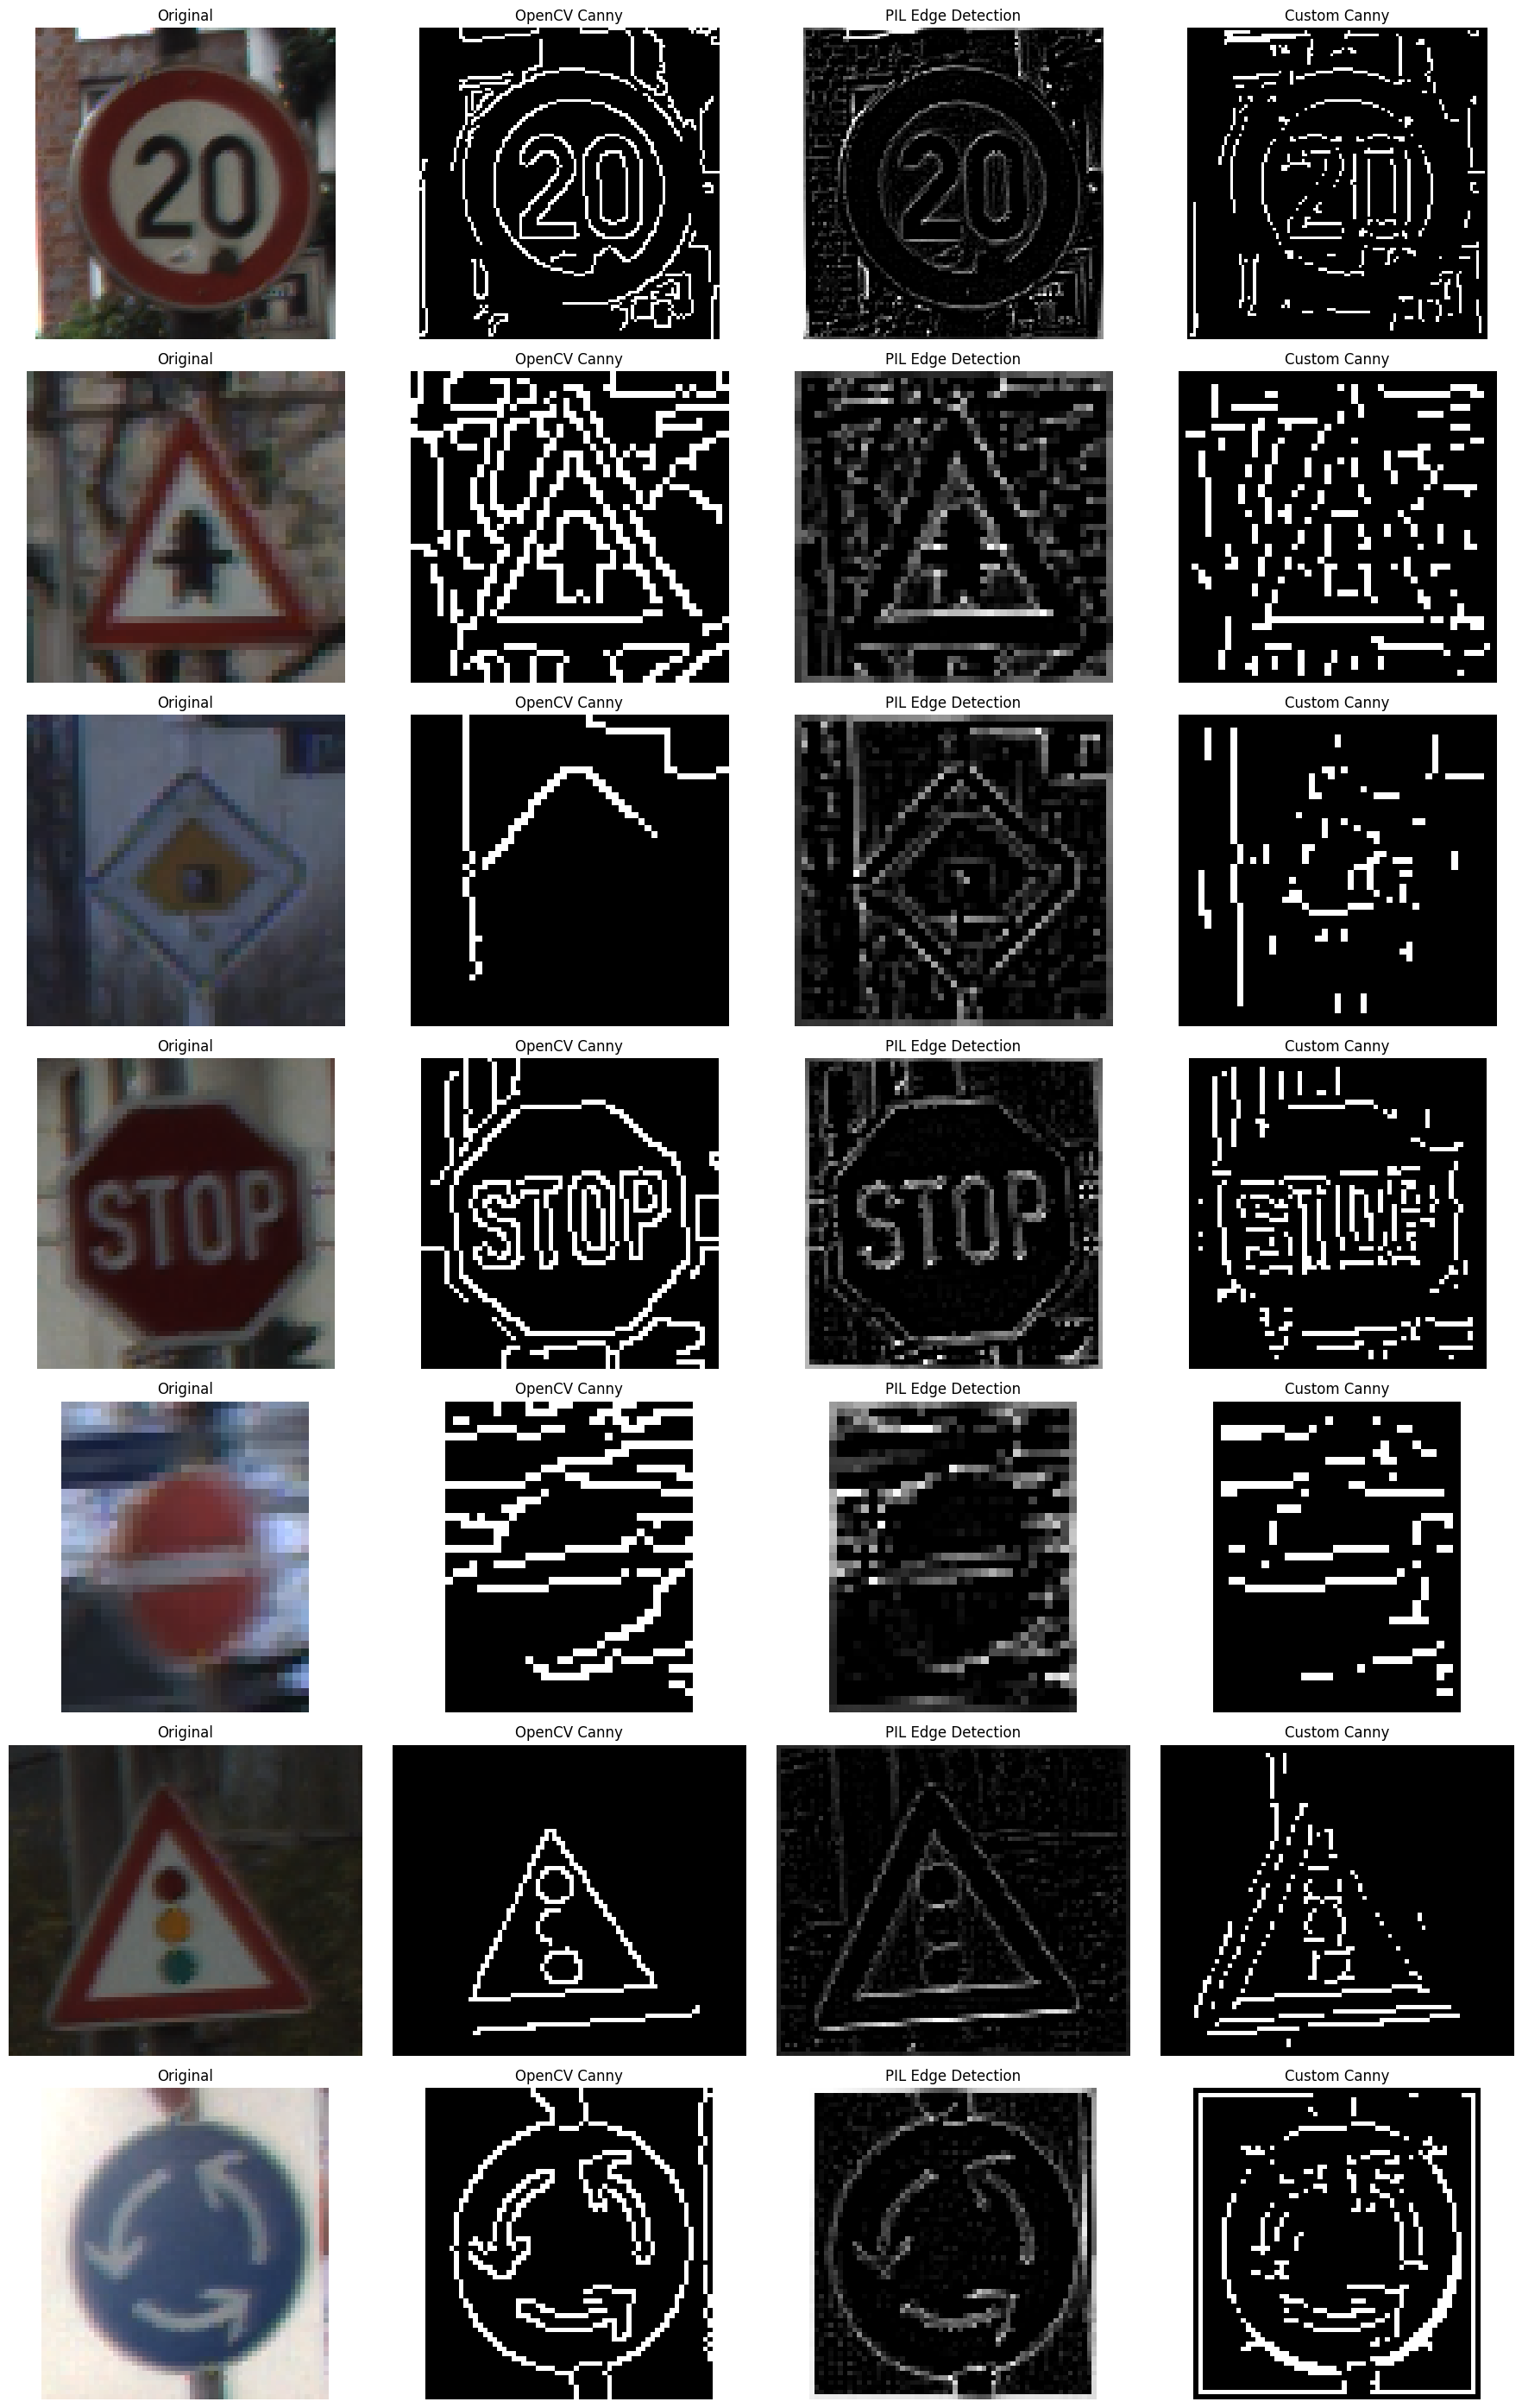

In [40]:
from PIL import Image, ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and process images
def process_and_display_edge_detection(image_paths):
    titles = ['Original', 'OpenCV Canny', 'PIL Edge Detection', 'Custom Canny']

    fig, axes = plt.subplots(len(image_paths), 4, figsize=(18, len(image_paths) * 4))

    for i, img_path in enumerate(image_paths):
        # Load the image
        img_cv = cv2.imread(img_path)
        img_cv_rgb = img_cv[:, :, ::-1]
        img_cv_gray = cv2.cvtColor(img_cv_rgb, cv2.COLOR_RGB2GRAY)

        img_pil = Image.open(img_path).convert('L')

        # Apply edge detection
        edges_cv = cv2.Canny(img_cv_gray, 100, 200)
        edges_pil = img_pil.filter(ImageFilter.FIND_EDGES)
        custom_edges = canny_edge(img_cv_rgb)

        # List of images to plot
        images = [img_cv_rgb, edges_cv, edges_pil, custom_edges]

        # Plot each image with its corresponding title
        for j, (ax, title, image) in enumerate(zip(axes[i], titles, images)):
            ax.imshow(image, cmap='gray' if j > 0 else None)
            ax.set_title(title)
            ax.axis('off')

    plt.tight_layout()
    plt.show()
# Process and display the images
process_and_display_edge_detection(imgs)


In [ ]:
display(HTML('<h1 style="font-size:80px; color:#5CCCCC; font-family:monospace;">Section 6</h1>'))

#Geometric Transform

1. Calculation of rotation angle and orientation alignment (10 marks)  
2. Construction and application of affine transform using NumPy (15 marks)  
3. Normalized signs scaled uniformly (10 marks)

Challenge: filling holes after rotation/scaling of images


In [42]:
#Rotate the sign to an upright orientation
# 1)Floating-point calculations involving sin(θ) and cos(θ) make the rotation process slow.

# 2)Pixel positions after rotation require interpolation, leading to blurring and loss of image sharpness.

# 3)Rounding errors accumulate due to repeated floating-point operations, causing distortions in the image.

def rotation(image, theta_deg): #expects a numpy array

    height, width, _  = image.shape
    rotated_img = np.zeros((height, width, 3), dtype=np.uint8)
    theta_rad = np.deg2rad(theta_deg)
    rotation_M = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],[np.sin(theta_rad), np.cos(theta_rad)]]) #rotation matrix
    cx, cy = height // 2, width // 2  #we will rotate  from the center of the image to center definition here

    for i in range(height):
        for j in range(width):
            x_coord = i - cx
            y_coord = j - cy
            x_rotated, y_rotated = rotation_M @ np.array([x_coord, y_coord])

            new_x = int(x_rotated + cx)
            new_y = int(y_rotated + cy)

            if new_x >= 0 and new_x < height and new_y >= 0 and new_y < width:
               rotated_img[new_x][new_y] = image[i][j]

    return rotated_img

# Reference:
# Yang, G., & Pavlidis, T. (1992). Double Line Image Rotation. Graphical Models and
# Image Processing, 54(2), 91–99. https://doi.org/10.1016/1049-9652(92)90024-9

### Method ###
"""
Double Line Image Rotation (DLR) Method:

- Calculate the rotation angle (alpha) and determine the operating zone (Horizontal or Vertical) based on the slope (tan(alpha)).
- Compute a base-line equation for each row or column: f(x) = (tan(alpha))x + b, where b ensures alignment and spacing consistency.
- Shift entire rows (H-zone) or columns (V-zone) along the base-lines to simulate rotation without rotating individual pixels.
- Adjust pixel distances when necessary, especially for rotations near 45 degrees, to maintain uniform pixel spacing and avoid distortion.
- Fill any unallocated pixels (holes) created during the line shifting process using nearest neighbor interpolation or simple averaging.
- Output the rotated image with preserved pixel structure, minimal interpolation artifacts, and high-quality visual results.
"""

def dlr_rotate(image, theta_deg): #expects a numpy array
    height, width, _  = image.shape
    rotated_img = np.zeros((height, width, 3), dtype=np.uint8)
    theta_rad = np.deg2rad(theta_deg)
    cx, cy = height // 2, width // 2  #we will rotate  from the center of the image to center definition here
    slope = np.tan(theta_rad)

    for x in range(height):
        shift = int(round((x - cx) * slope ))
        for y in range(width):
            new_y = y + shift
            if new_y >= 0 and new_y < width:
                rotated_img[x][new_y] = image[x,y]

    return rotated_img #limitation: needs preprocessing at for large angles, works well for small angles

#I found a cubic/spline interpolation method for image scaling so
#I used it for rotation too

def cubic_kernel(d):
    """Cubic interpolation kernel function."""
    absd = np.abs(d)
    absd2 = absd**2
    absd3 = absd**3
    k = (absd <=1) * (1.5 * absd3 - 2.5 * absd2 + 1) + ((absd > 1) & (absd <= 2)) *  (-0.5 * absd3 + 2.5 * absd2 - 4 * absd + 2)
    #above is if else without if else
    return k

def get_cubic_value(image, x, y, c):

    height, width, _ = image.shape
    neighbourhood = np.zeros((4, 4)) # 4x4 neighbourhood

    x0 = int(x) #get integer values
    y0 = int(y)
    for i in range(-1,3):
        for j in range(-1,3):
            xn = np.clip(x0 + i, 0, width -1)
            yn = np.clip(y0 + j, 0, height-1)
            neighbourhood[j+1][i+1] = image[yn][xn][c]

    dx = x - x0 #find difference between the past and present pixel
    dy = y - y0

    #weights for interpolation
    wx = np.array([cubic_kernel(dx + 1), cubic_kernel(dx), cubic_kernel(dx - 1), cubic_kernel(dx - 2)])
    wy = np.array([cubic_kernel(dy + 1), cubic_kernel(dy), cubic_kernel(dy - 1), cubic_kernel(dy - 2)])

    interpolated = np.dot(np.dot(wy, neighbourhood), wx)

    return np.clip(interpolated, 0, 255)


#question: How will we find the angle? say we are given a image tilted to the side, how do we find by what angle it has to be rotated
def rotation_spline(image, theta_deg):
    """Rotation using cubic interpolation."""
    height, width, _ = image.shape
    rotated_img = np.zeros((height, width, 3), dtype=np.uint8)

    theta_rad = np.deg2rad(theta_deg)
    rotation_M = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],[np.sin(theta_rad), np.cos(theta_rad)]]) #rotation matrix

    cx = width // 2
    cy = height // 2  # center coordinates

    for y in range(height):
        for x in range(width):
            x_coord = x - cx
            y_coord = y - cy
            x_rotated, y_rotated = rotation_M @ np.array([x_coord, y_coord]) #returns values in float

            new_x = x_rotated + cx
            new_y = y_rotated + cy


            if 0 <= new_x < width and 0 <= new_y < height:
                for c in range(3):  # For each RGB channel
                    rotated_img[y, x, c] = get_cubic_value(image, new_x, new_y, c)

    return rotated_img

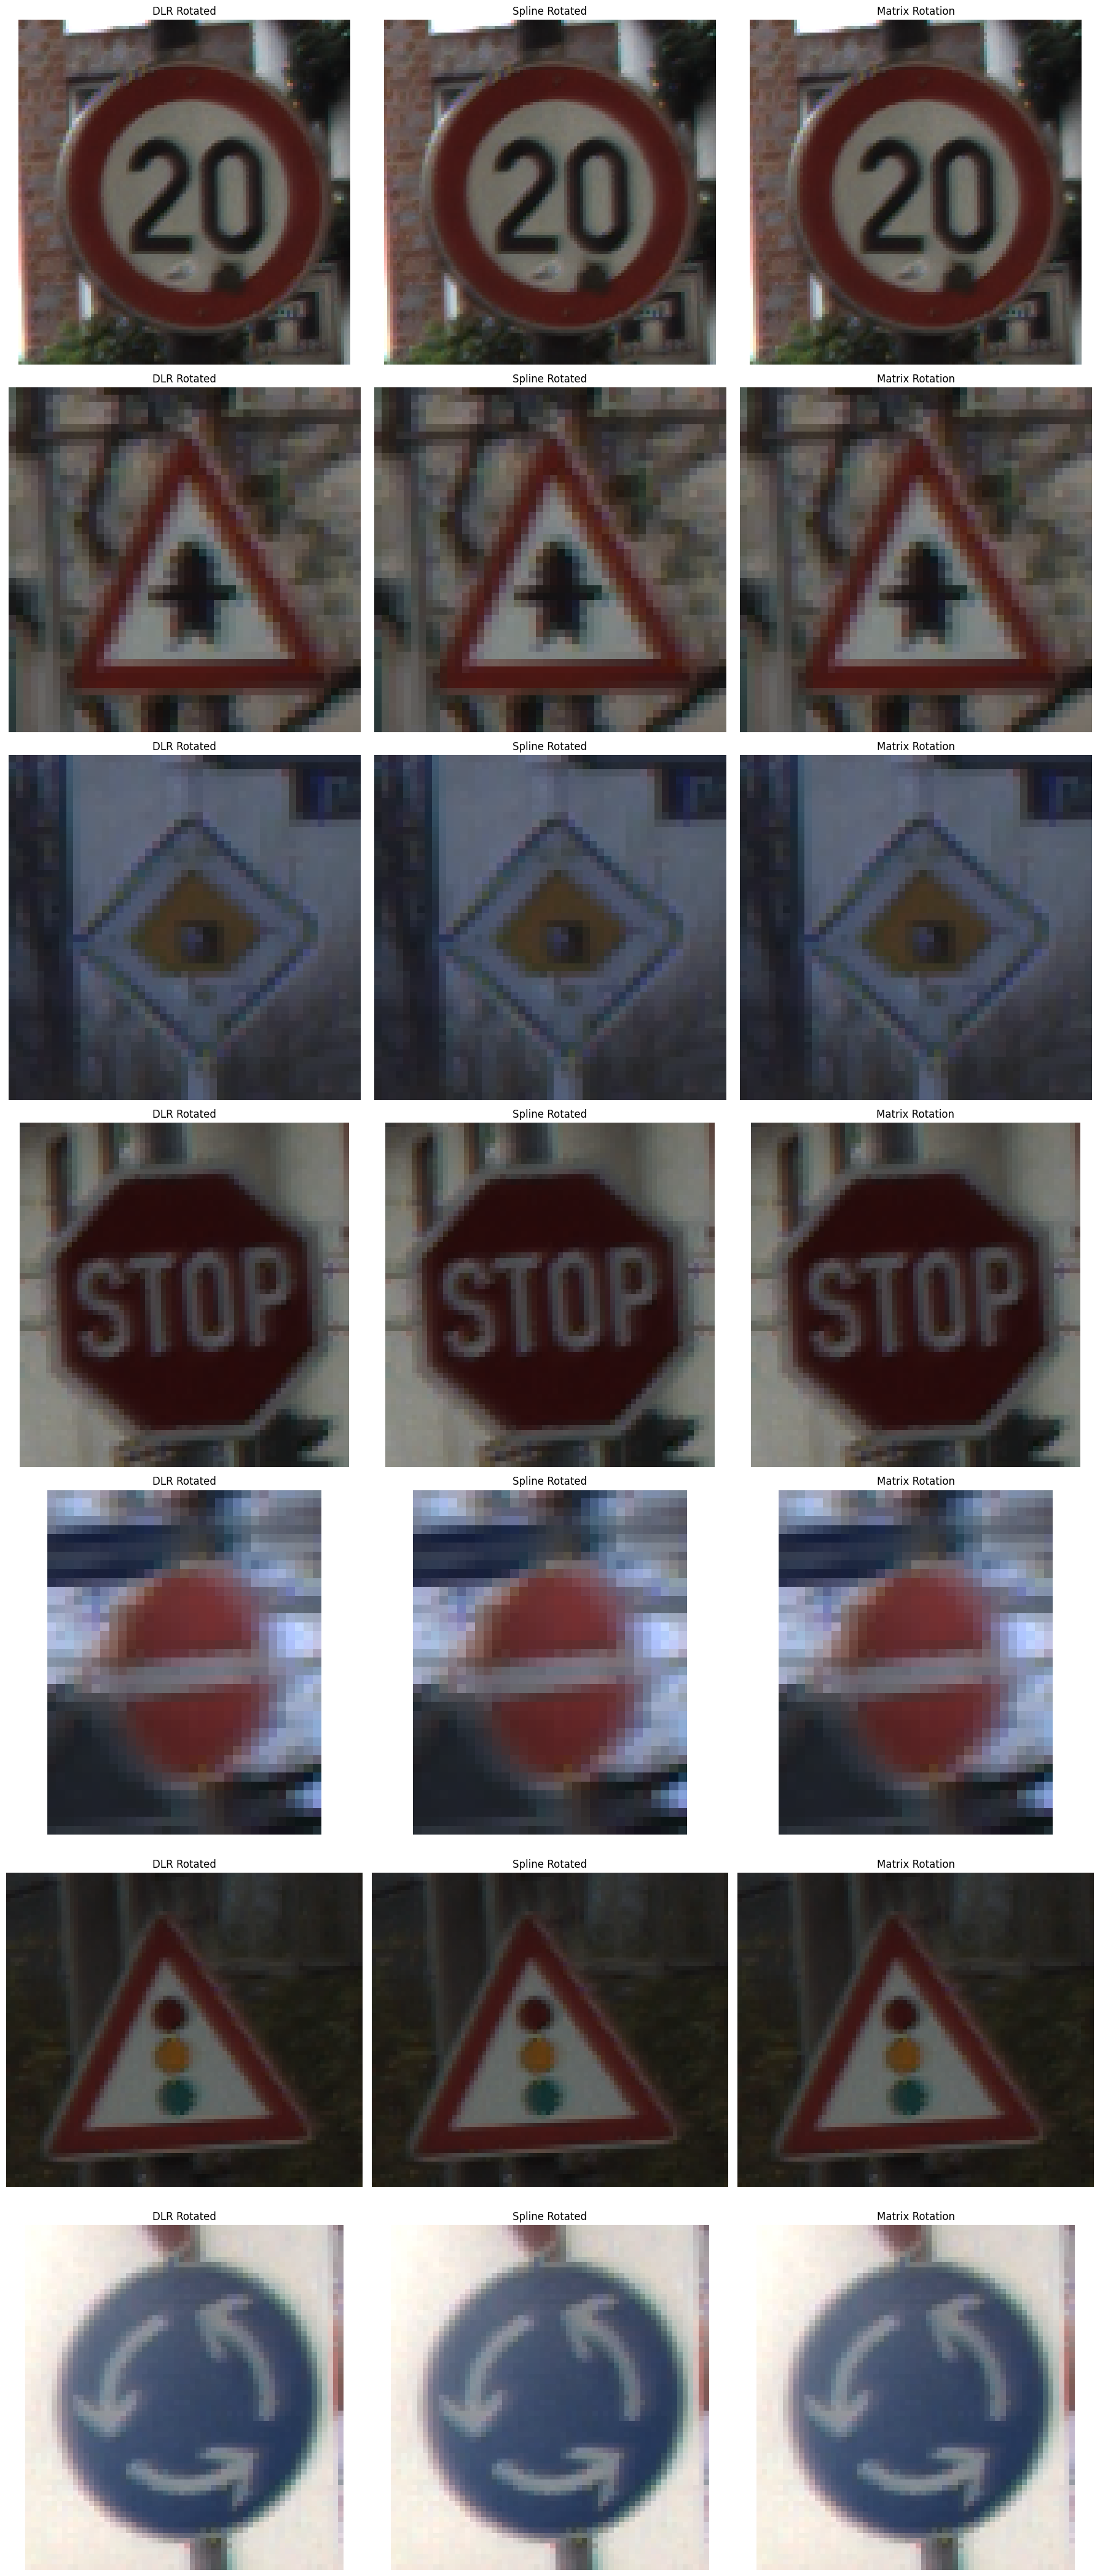

In [44]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming the functions dlr_rotate, rotation_spline, and rotation are defined as per your provided code.

def process_and_display_rotations(image_paths):
    titles = ['DLR Rotated', 'Spline Rotated', 'Matrix Rotation']

    fig, axes = plt.subplots(len(image_paths), 3, figsize=(18, len(image_paths) * 6))

    for i, img_path in enumerate(image_paths):
        # Load the image as a NumPy array for rotation functions
        img_cv = cv2.imread(img_path)
        img_cv_rgb = img_cv[:, :, ::-1]  # Convert to RGB for OpenCV

        # Convert PIL image to NumPy array for processing with existing functions
        img_pil = Image.open(img_path).convert('RGB')
        img_pil_rgb = np.array(img_pil)

        # Apply rotations
        dlr = dlr_rotate(img_pil_rgb, 0)  # DLR rotation
        spline = rotation_spline(img_cv_rgb, 0)  # Spline (Cubic) rotation
        matrix_rotation = rotation(img_cv_rgb, 0)  # Matrix rotation

        # List of rotated images
        rotated_images = [dlr, spline, matrix_rotation]

        # Plot each rotated image with its corresponding title
        for j, (ax, title, rotated_img) in enumerate(zip(axes[i], titles, rotated_images)):
            ax.imshow(rotated_img)
            ax.set_title(title)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

process_and_display_rotations(imgs)


In [52]:
#Scale to a fixed size (e.g., 200×200 pixels)
def scaled(image, sx, sy): #expects a numpy array

    height, width, _  = image.shape
    scaled_img = np.zeros((height, width, 3), dtype=np.uint8)
    scale_M = np.array([[sx, 0],[0, sy]]) #rotation matrix
    cx, cy = height // 2, width // 2  #we will rotate  from the center of the image to center definition here

    for i in range(height):
        for j in range(width):
            x_coord = i - cx
            y_coord = j - cy
            x_scaled, y_scaled = scale_M @ np.array([x_coord, y_coord])

            new_x = x_scaled + cx
            new_y = y_scaled + cy

            if new_x >= 0 and new_x < height and new_y >= 0 and new_y < width:
                scaled_img[new_x][new_y] = image[i][j]

    return scaled_img

# Reference:
# Parveen, S., & Tokas, R. (2015). Faster Image Zooming using Cubic Spline Interpolation Method. International
# Journal on Recent and Innovation Trends in Computing and Communication, 3(1), 22–26. http://www.ijritcc.org
### Method ###
"""
Cubic Spline Image Scaling Method (for RGB Images):

- Split the input RGB image into 3 separate channels (Red, Green, and Blue).

- For each channel:
    - Resize along the width:
        - Generate new target x-positions according to the scaling factor.
        - For each new x-position:
            - Find 4 neighboring original pixels.
            - Apply the cubic interpolation kernel to compute a weighted average.
    - Resize along the height:
        - Generate new target y-positions.
        - For each new y-position:
            - Find 4 neighboring original pixels (from the resized width).
            - Apply the cubic interpolation kernel again to compute smooth values.

- The cubic kernel function:
    - Calculates interpolation weights based on distance.
    - Nearby pixels have more influence; distant pixels have less.
    - Ensures a smooth transition between pixels (third-degree polynomial).

- After resizing width and height:
    - Stack the 3 resized channels back together into a final RGB image.

- Clip the resulting pixel values to the valid [0, 255] range to ensure proper image intensity.
"""


def interpolate_1d(data, new_length):
    """1D cubic interpolation on a 1D array."""
    old_length = len(data)
    scale = old_length / new_length
    output = np.zeros(new_length)

    for i in range(new_length):
        x = i * scale
        x0 = int(x)

        # 4 neighbors: x0-1, x0, x0+1, x0+2
        neighbours = np.zeros(4)
        for j in range(-1, 3):
            idx = np.clip(x0 + j, 0, old_length - 1)
            neighbours[j + 1] = data[idx]

        # Weights from cubic kernel
        dx = x - x0
        w = np.array([cubic_kernel(dx + 1), cubic_kernel(dx), cubic_kernel(dx - 1), cubic_kernel(dx - 2)])
        output[i] = np.dot(w, neighbours)

    return output
def cubic_resize_gray(image, scale_x, scale_y):
    """Resize 2D grayscale image using cubic interpolation."""
    old_height, old_width = image.shape
    new_height = int(old_height * scale_y)
    new_width = int(old_width * scale_x)

    # First resize along x (columns)
    temp = np.zeros((old_height, new_width))
    for i in range(old_height):
        temp[i, :] = interpolate_1d(image[i, :], new_width)

    # Then resize along y (rows)
    resized = np.zeros((new_height, new_width))
    for j in range(new_width):
        resized[:, j] = interpolate_1d(temp[:, j], new_height)

    return np.clip(resized, 0, 255).astype(np.uint8)

def scaled_spline(image_rgb, scale_x, scale_y):
    """Resize 3D RGB image using cubic interpolation."""
    channels = []
    for c in range(3):  # R, G, B channels
        channel = image_rgb[:, :, c]
        resized_channel = cubic_resize_gray(channel, scale_x, scale_y)
        channels.append(resized_channel)

    # Stack back the channels
    resized_rgb = np.stack(channels, axis=-1)
    return resized_rgb


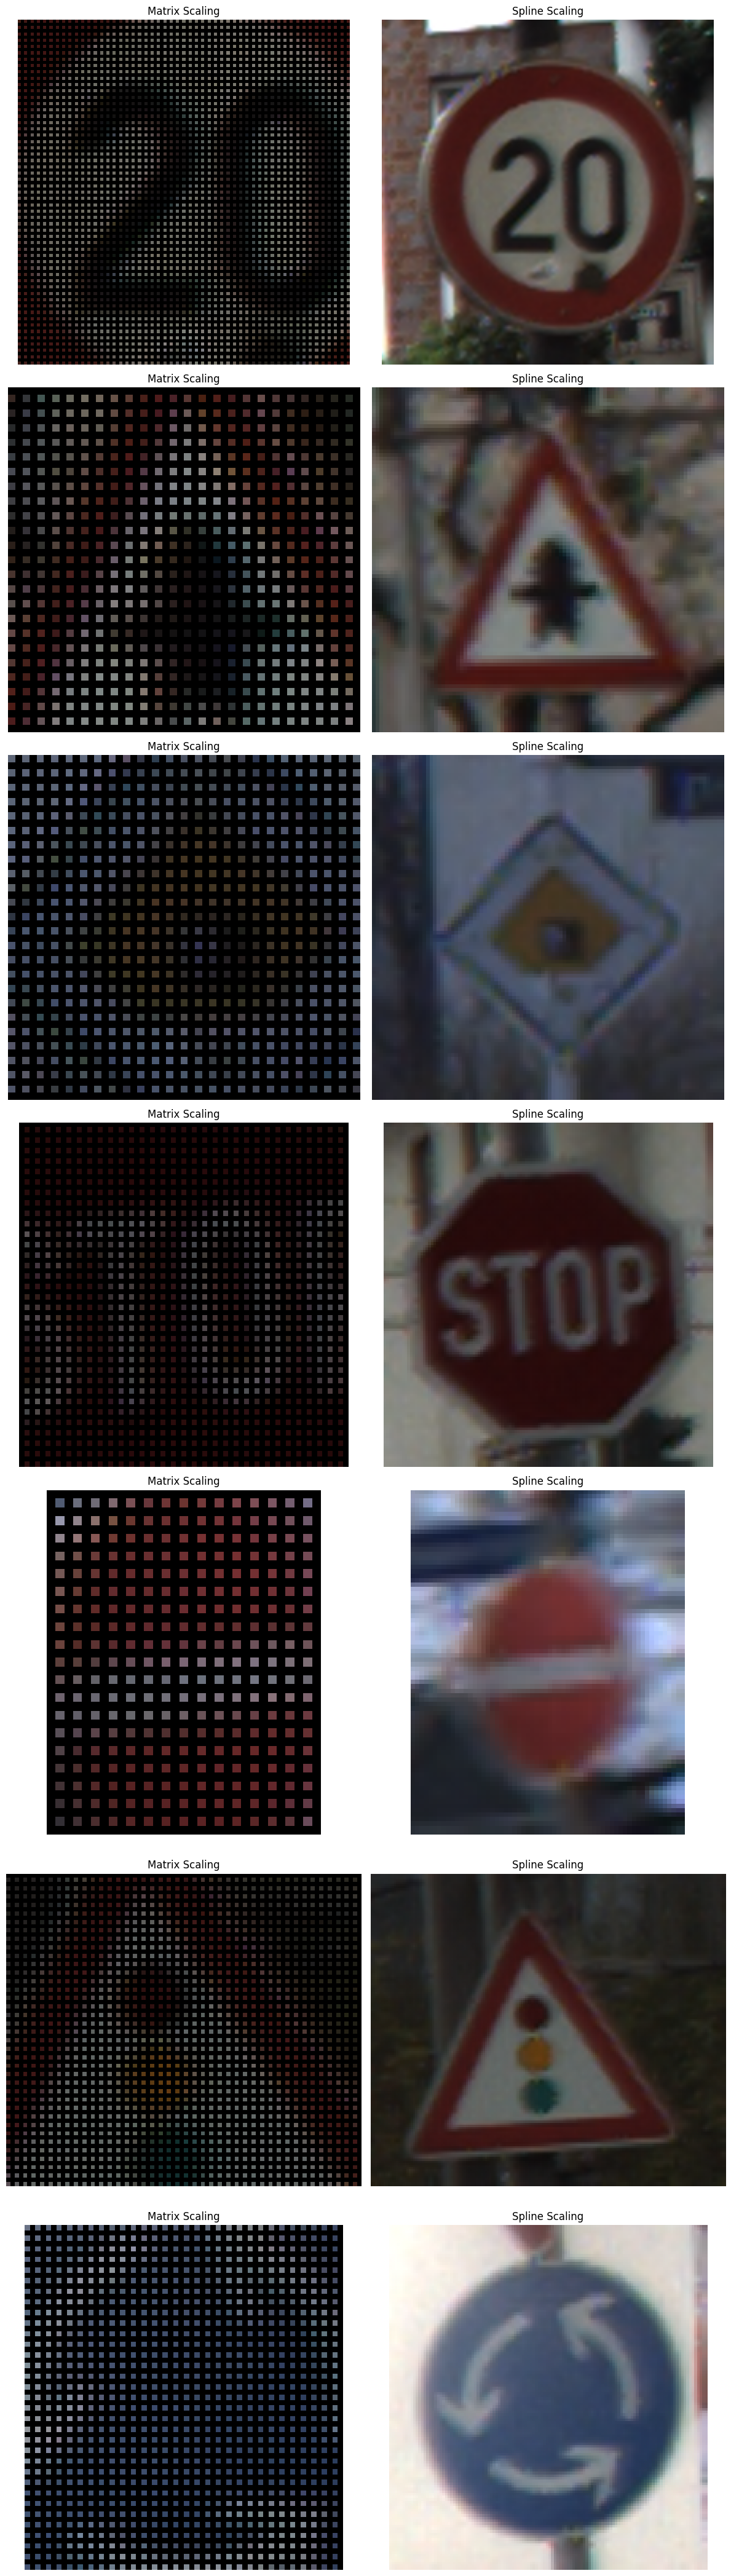

In [55]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to process and display scaled images
def process_and_display_scaling(image_paths, scale_x=2, scale_y=2):
    titles = ['Matrix Scaling', 'Spline Scaling']

    fig, axes = plt.subplots(len(image_paths), 2, figsize=(12, len(image_paths) * 6))

    for i, img_path in enumerate(image_paths):
        # Load image using OpenCV and convert to RGB
        img_cv = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

        # Apply scaling methods
        scaled_matrix = scaled(img_rgb.copy(), scale_x, scale_y)  # matrix scaling
        scaled_spline_img = scaled_spline(img_rgb.copy(), scale_x, scale_y)  # spline interpolation

        # List of scaled images
        scaled_images = [scaled_matrix, scaled_spline_img]

        for j, (ax, title, scaled_img) in enumerate(zip(axes[i], titles, scaled_images)):
            ax.imshow(scaled_img)
            ax.set_title(f'{title}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

process_and_display_scaling(imgs, 2, 2)


In [56]:
#Perspective transform

# === Reference for Perspective Transformation / Homography ===

# Zhang, Z. (2000). A flexible new technique for camera calibration.
# IEEE Transactions on Pattern Analysis and Machine Intelligence, 22(11), 1330–1334.
# https://doi.org/10.1109/34.888718
# → This paper introduces a homography-based method for estimating camera parameters.
# → Your implementation of homography via SVD on 4+ point correspondences aligns with Zhang’s method.
# → However, your code omits camera intrinsics and distortion correction, which are part of Zhang’s full calibration framework.

def find_perspective(src_pts, dts_pts): #not yet complete
    A = []
    h = None
    for i in range(4):
        x = src_pts[i][0]
        y = src_pts[i][1]
        u = dts_pts[i][0]
        v = dts_pts[i][1]
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    A = np.array(A)
    _,_,Vt = np.linalg.svd(A)
    h = Vt[-1].reshape(3,3)
    return h

def perspective_transform(input_image, src_pts, dst_pts):
    height, width, _ = input_image.shape
    H_matrix = find_perspective(src_pts, dst_pts)#find perspective matrix
    p_trans_img = np.zeros((height, width, 3), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            x_new, y_new, w = np.linalg.inv(H_matrix) @ np.array([x, y, 1])
            x_new /= w
            y_new /= w
            if x_new >= 0 and x_new < width and y_new >= 0 and y_new < height:
                for c in range(3):  # For each RGB channel
                    p_trans_img[y, x, c] = get_cubic_value(input_image, x_new, y_new, c)

    return p_trans_img


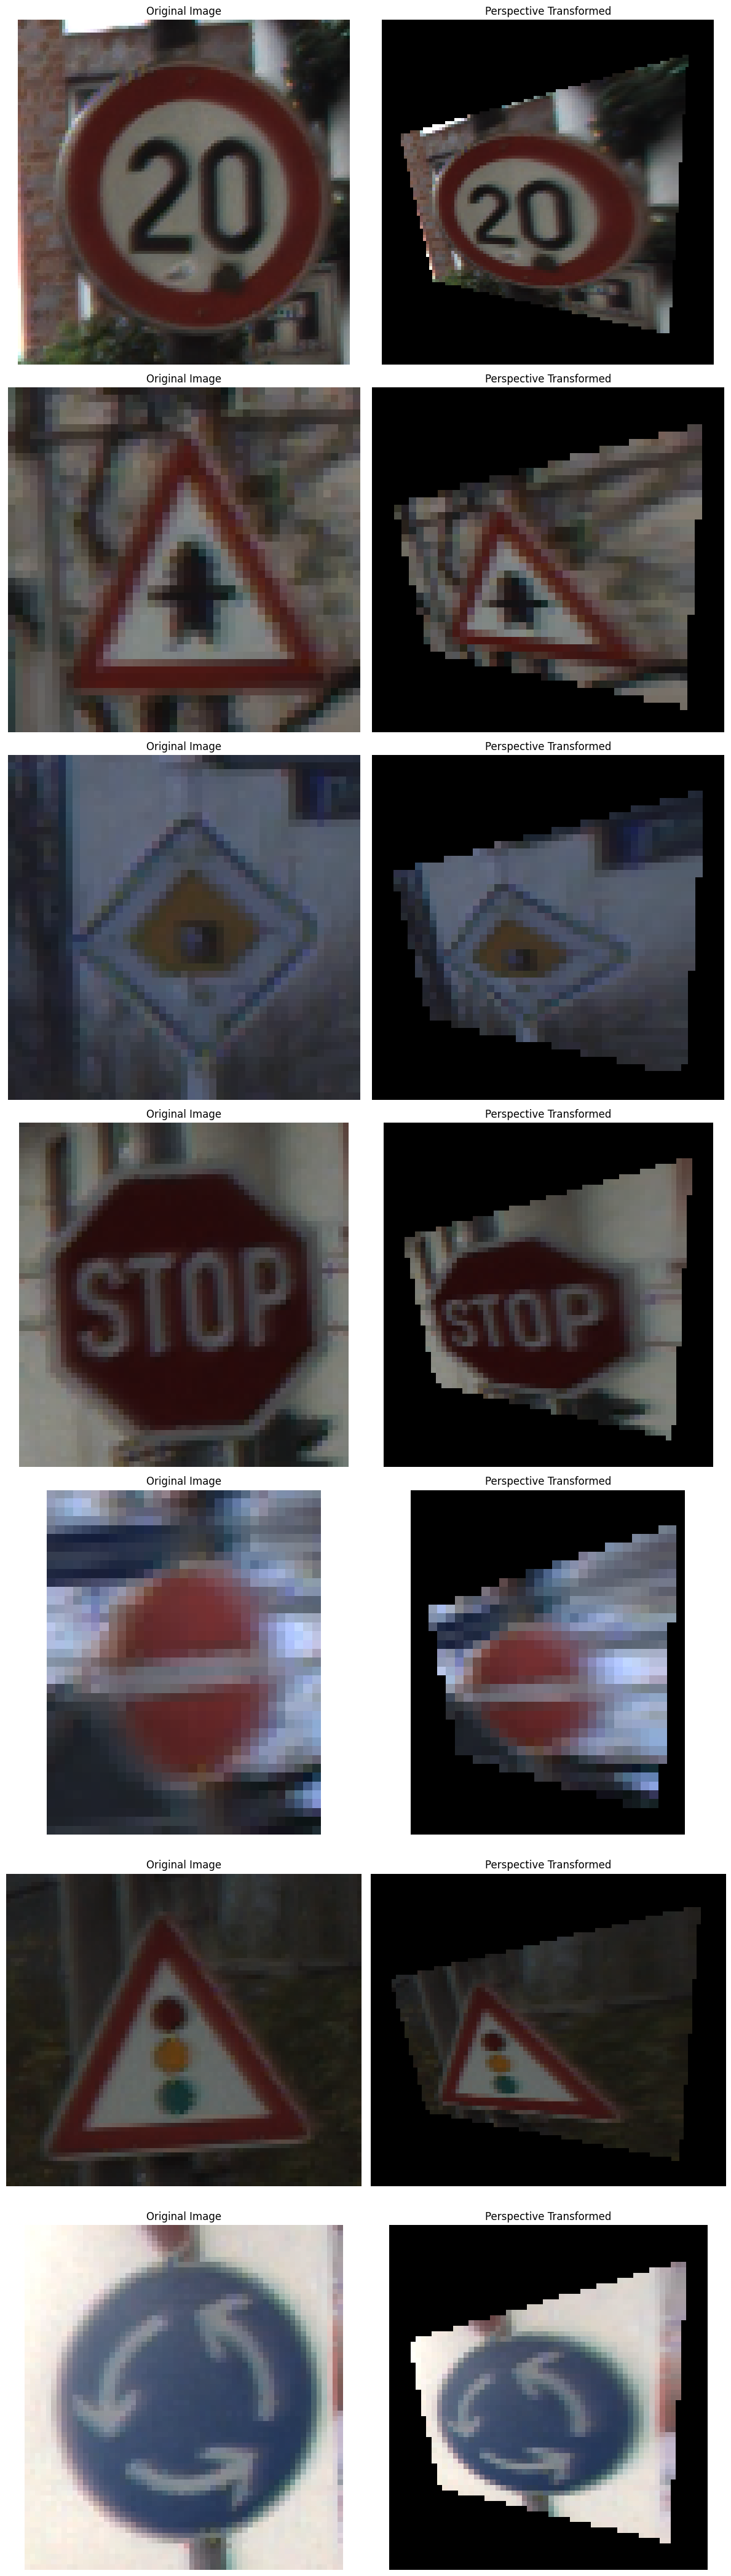

In [60]:
def process_and_display_perspective_images(image_paths):
    fig, axes = plt.subplots(len(image_paths), 2, figsize=(12, len(image_paths) * 6))

    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]

        # Define example perspective points (can be adjusted or made dynamic)
        src_pts = [(0, 0), (w-1, 0), (w-1, h-1), (0, h-1)]
        dst_pts = [(w*0.05, h*0.33), (w*0.9, h*0.1), (w*0.85, h*0.9), (w*0.15, h*0.75)]

        transformed = perspective_transform(img_rgb, src_pts, dst_pts)

        axes[i][0].imshow(img_rgb)
        axes[i][0].set_title("Original Image")
        axes[i][0].axis('off')

        axes[i][1].imshow(transformed)
        axes[i][1].set_title("Perspective Transformed")
        axes[i][1].axis('off')

    plt.tight_layout()
    plt.show()

process_and_display_perspective_images(imgs)

In [ ]:
display(HTML('<h1 style="font-size:80px; color:#FAC18C; font-family:monospace;">Section 7</h1>'))

In [ ]:
#@title **Feature Extraction**

# **Feature Extraction**



1.   Implementation of Harris corner detection (25 marks)
2.   Accurate corner count, circularity computation (25 marks)
3.   Correct calculation of aspect ratio and extent (25 marks)
4. Use of average hue or color dominance as a feature (20 marks)
5. Feature normalization or transformation if applied (Bonus: 10 marks)



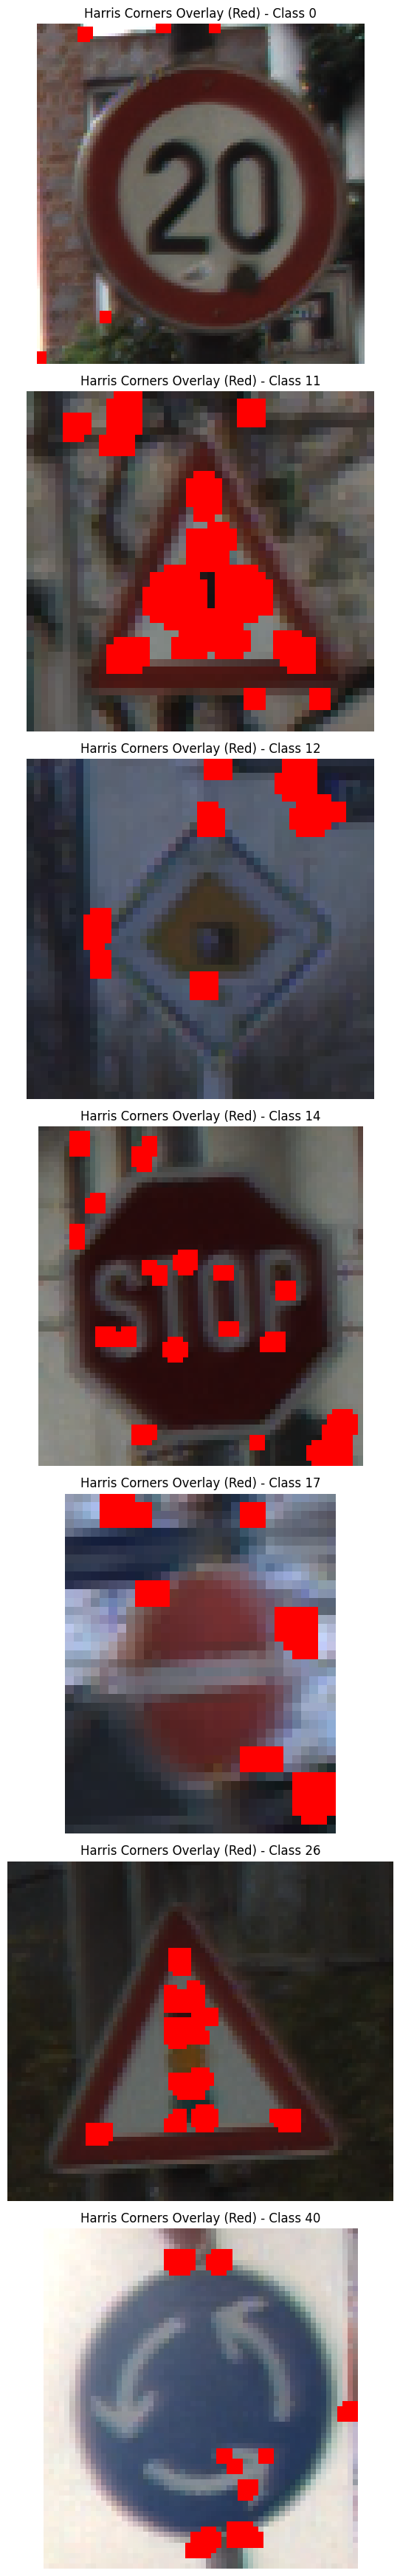

In [62]:
# === Reference (APA Style) for Harris Corner Detection ===

# Harris, C., & Stephens, M. (1988). A combined corner and edge detector.
# In Proceedings of the Alvey Vision Conference (pp. 147–151).
# https://www.bmva.org/bmvc/1988/avc-88-023.pdf
# → This paper introduces the Harris corner detector based on the eigenvalues of the structure tensor.
# → Your implementation follows this pipeline:
#    1. Convert to grayscale
#    2. Compute image gradients (Ix, Iy)
#    3. Form the structure tensor M = [Ix², IxIy; IxIy, Iy²]
#    4. Apply Gaussian smoothing to the components
#    5. Compute the Harris response R = det(M) - k*(trace(M))²
# → Differences: Your code omits non-maximum suppression and sub-pixel corner refinement found in more advanced variants.

def gray_scale_img(image):
    if image.ndim == 3:
        return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])  # R, G, B weights
    return image

def pad_image(img, pad_size, mode='constant'):
    return np.pad(img, ((pad_size, pad_size), (pad_size, pad_size)), mode=mode)

def gaussian_filter(img, sigma=1):  # handles 2D input
    size = int(2 * np.ceil(3 * sigma) + 1)
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / np.sum(kernel)

    padded = pad_image(img, size // 2)
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i + size, j:j + size]
            filtered[i, j] = np.sum(region * kernel)
    return filtered

def sobel(img):
    Kx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])

    dx = cv2.filter2D(img, -1, Kx)
    dy = cv2.filter2D(img, -1, Ky)
    magnitude = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)
    return magnitude, theta, dx, dy

def harris_corner(image, k):
    img = gray_scale_img(image)
    magnitude, theta, dx, dy = sobel(img)

    # Gaussian Filter
    Ixx = gaussian_filter(dx ** 2, sigma=1)
    Iyy = gaussian_filter(dy ** 2, sigma=1)
    Ixy = gaussian_filter(dx * dy, sigma=1)

    R = (Ixx * Iyy - Ixy ** 2) - k * ((Ixx + Iyy) ** 2)

    threshold = 0.1 * np.max(R)
    corners = R > threshold

    return corners.astype(np.uint8)

def overlay_corners_on_image(image, corners):
    overlay = image.copy()
    ys, xs = np.where(corners == 1)
    for y, x in zip(ys, xs):
        if 1 <= y < overlay.shape[0] - 1 and 1 <= x < overlay.shape[1] - 1:
            overlay[y-1:y+2, x-1:x+2] = [255, 0, 0]  # Red square
    return overlay

def process_and_display_harris_corners(image_paths):
    fig, axes = plt.subplots(len(image_paths), 1, figsize=(10, len(image_paths) * 5))

    if len(image_paths) == 1:
        axes = [axes]

    for i, img_path in enumerate(image_paths):
        # === Load and process image ===
        img_cv = cv2.imread(img_path)
        img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

        corners = harris_corner(img_cv_rgb, k=0.05)
        output_img = overlay_corners_on_image(img_cv_rgb, corners)

        # === Display result ===
        axes[i].imshow(output_img)
        class_id = os.path.basename(os.path.dirname(img_path))
        axes[i].set_title(f"Harris Corners Overlay (Red) - Class {class_id}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

process_and_display_harris_corners(imgs)

## Library Implemenration as tester

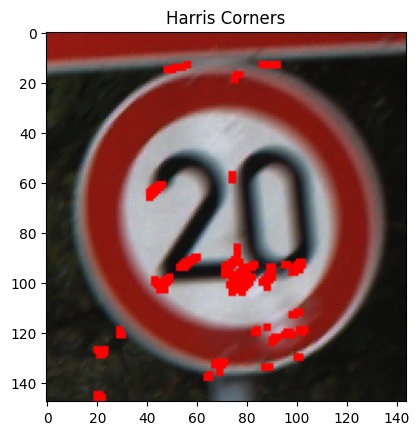

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and convert to grayscale
img = cv2.imread('/content/drive/MyDrive/traffic_dataset_subset/train/0/00000_00000_00029.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Harris corner detection
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Dilate result to mark the corners
dst = cv2.dilate(dst, None)

# Threshold to mark corners in red
img[dst > 0.01 * dst.max()] = [0, 0, 255]

# Show result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Harris Corners')
plt.show()


In [86]:
#circularity
def otsu_threshold(image):
    # Flatten the image and calculate histogram
    pixel_counts, bin_edges = np.histogram(image.ravel(), bins=256, range=(0, 256))
    total_pixels = image.size

    sum_total = np.dot(np.arange(256), pixel_counts)
    sum_bg = 0
    weight_bg = 0
    max_var_between = 0
    threshold = 0

    for t in range(256):
        weight_bg += pixel_counts[t]
        if weight_bg == 0:
            continue
        weight_fg = total_pixels - weight_bg
        if weight_fg == 0:
            break

        sum_bg += t * pixel_counts[t]
        mean_bg = sum_bg / weight_bg
        mean_fg = (sum_total - sum_bg) / weight_fg

        var_between = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2

        if var_between > max_var_between:
            max_var_between = var_between
            threshold = t

    return threshold


def calculate_perimeter(contour):
    """Estimate perimeter as the number of edge pixels using erosion."""
    p = 0
    perimeter = 0
    for i in range(1, len(contour)):
        dx = contour[i][0] - contour[i-1][0]
        dy = contour[i][1] - contour[i-1][1]
        perimeter += np.sqrt(dx**2 + dy**2)
    return perimeter
def calculate_area(contour):
    """
    Computes area of a polygon using the shoelace formula.
    Input: contour as a list of (x, y) tuples or a 2D NumPy array
    """
    if len(contour) < 3:
        return 0  # Not a valid polygon
    contour = np.array(contour)
    x = contour[:, 0]
    y = contour[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def find_largest(contours):
    """
    Finds the largest contour based on polygon area.
    Input: contours is a list of arrays of (x, y) points
    Returns: the largest contour
    """
    if not contours:
        return None

    max_area = 0
    largest = None
    for contour in contours:
        area = polygon_area(contour)
        if area > max_area:
            max_area = area
            largest = contour
    return largest

def circularity(image):
  """Computes circularity from scratch using:
    Circularity = 4π × Area / Perimeter²
  """
  img = gray_scale_img(image)
  bin = img > otsu_threshold(img)
  contours, _, _, _ = sobel(bin)
  c = find_largest(contours)
  area = calculate_area(c)
  perimeter = calculate_perimeter(c)
  if perimeter == 0:
    return 0.0

  # Calculate circularity
  circularity = (4 * np.pi * area) / (perimeter ** 2)\

  return circularity

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_circularity_cv2(image):
    """
    Compute and visualize the circularity of the largest contour in a binary image.

    Parameters:
    - image: Input image (RGB or grayscale)

    Returns:
    - circularity: Float value indicating how circular the shape is
    - img_vis: Image with contour drawn
    """
    # Convert to grayscale if needed
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Threshold to binary
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found.")
        return 0.0, image

    # Use the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)

    if perimeter == 0:
        return 0.0, image

    # Calculate circularity
    circularity = (4 * np.pi * area) / (perimeter ** 2)

    # Draw contour
    img_vis = image.copy()
    if image.ndim == 2:
        img_vis = cv2.cvtColor(img_vis, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_vis, [largest_contour], -1, (0, 0, 255), 2)

    return circularity, img_vis


# Library implementation

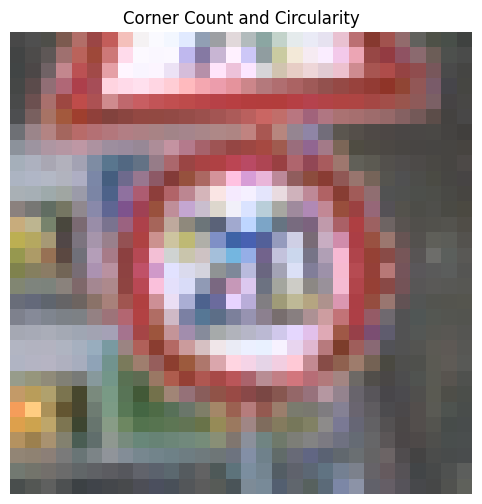

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load Image ---
img = cv2.imread('/content/drive/MyDrive/traffic_dataset_subset/train/0/00000_00000_00002.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Edge Detection ---
edges = cv2.Canny(img_gray, 100, 200)

# --- Find Contours ---
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# --- Process each contour ---
for contour in contours:
    # Skip small areas (noise)
    if cv2.contourArea(contour) < 500:
        continue

    # Polygon approximation (Corner Detection)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corner_count = len(approx)

    # Circularity Calculation
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        continue  # avoid divide by zero
    circularity = 4 * np.pi * area / (perimeter * perimeter)

    # Draw and Annotate
    cv2.drawContours(img, [approx], -1, (0, 255, 0), 2)
    x, y, w, h = cv2.boundingRect(approx)
    text = f"Corners: {corner_count}, Circ: {circularity:.2f}"
    cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# --- Show Result ---
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title("Corner Count and Circularity")
plt.axis('off')
plt.show()


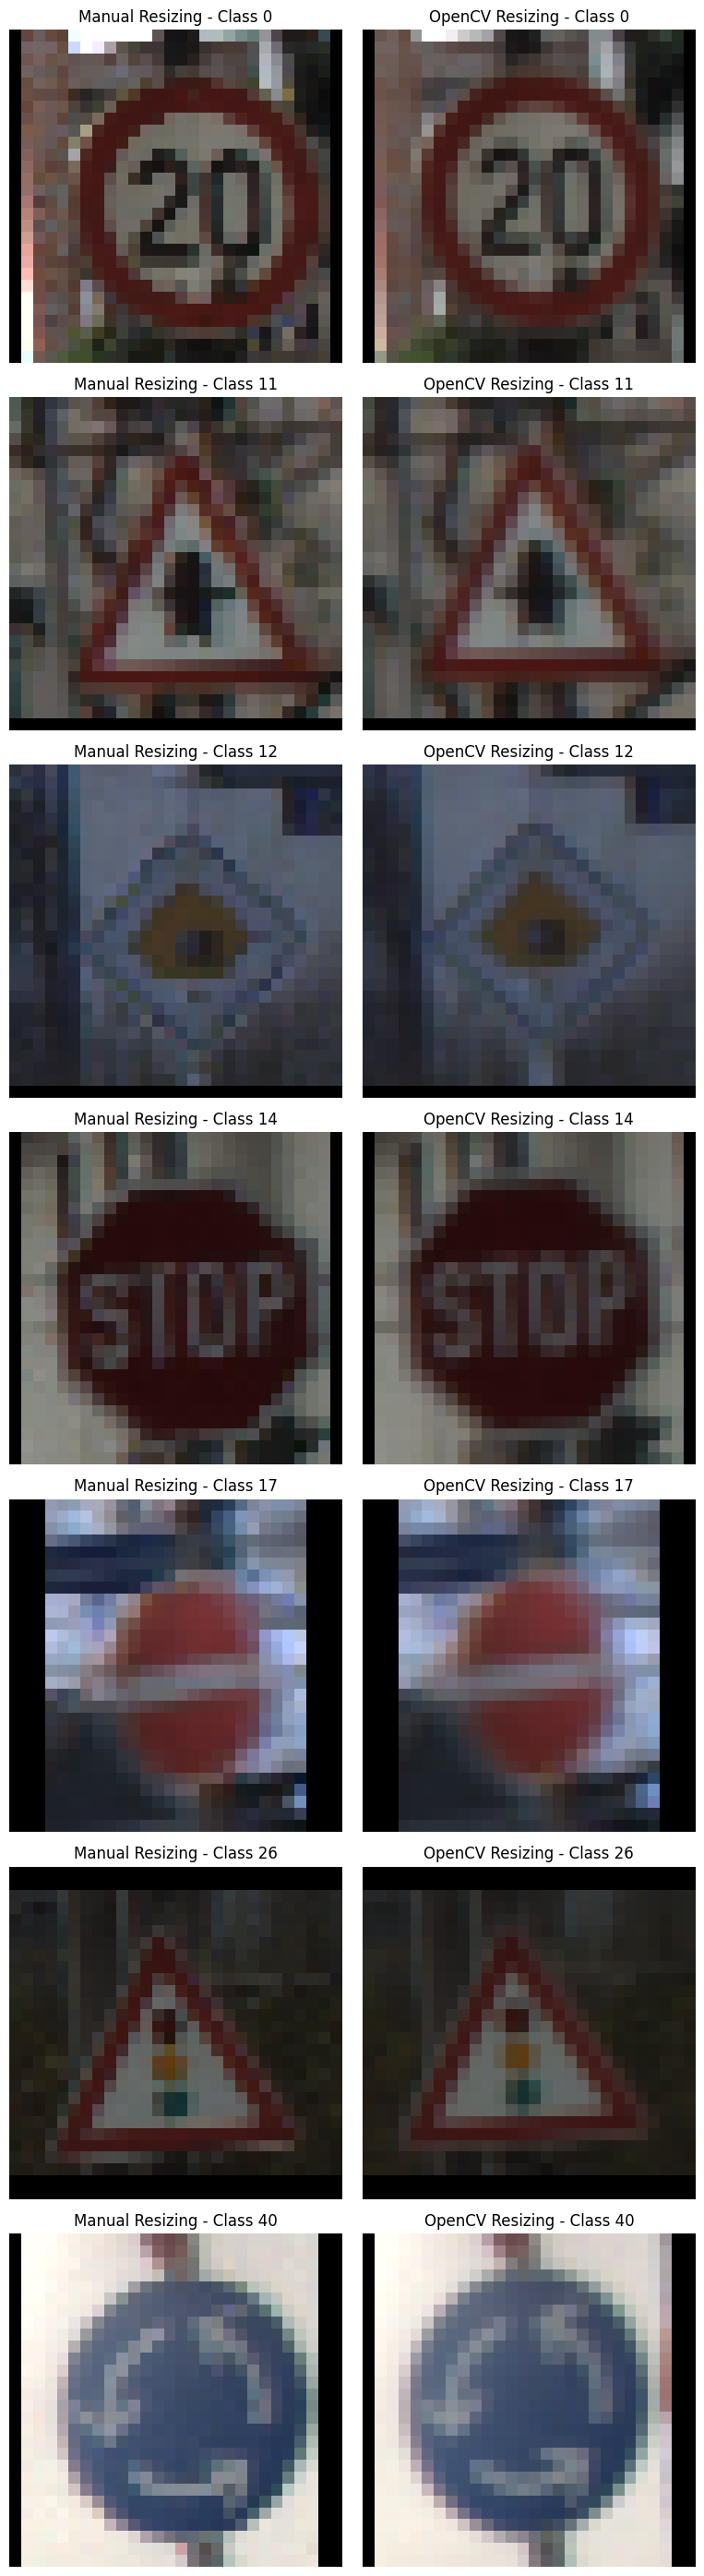

In [67]:
def resize_with_aspect_ratio(image_array, target_size=(28, 28)):
    """
    Resize the image while preserving the aspect ratio and pad to target size.

    Parameters:
    - image_array: 2D or 3D NumPy array (grayscale or RGB)
    - target_size: tuple (height, width)

    Returns:
    - Resized and padded image as NumPy array of shape target_size
    """
    orig_h, orig_w = image_array.shape[:2]
    target_h, target_w = target_size

    # Compute scale while preserving aspect ratio
    scale = min(target_w / orig_w, target_h / orig_h)
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)

    # Resize using simple nearest-neighbor interpolation
    resized = np.zeros((new_h, new_w, *image_array.shape[2:]), dtype=image_array.dtype)
    for i in range(new_h):
        for j in range(new_w):
            orig_i = int(i / scale)
            orig_j = int(j / scale)
            resized[i, j] = image_array[orig_i, orig_j]

    # Padding to center the resized image
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left

    if image_array.ndim == 3:
        padded = np.zeros((target_h, target_w, image_array.shape[2]), dtype=image_array.dtype)
    else:
        padded = np.zeros((target_h, target_w), dtype=image_array.dtype)

    padded[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized
    return padded

def resize_with_aspect_ratio_cv2(image, target_size=(28, 28), pad_color=0):
    """
    Resize an image while preserving aspect ratio and padding to fit the target size.

    Parameters:
    - image: input image as NumPy array (grayscale or RGB)
    - target_size: desired output size (height, width)
    - pad_color: padding color (0 for black)

    Returns:
    - Padded resized image as NumPy array of shape (target_size)
    """
    h, w = image.shape[:2]
    target_h, target_w = target_size

    # Compute scale and new size
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize using OpenCV
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Compute padding
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left

    if len(image.shape) == 3:
        padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right,
                                    borderType=cv2.BORDER_CONSTANT, value=[pad_color]*3)
    else:
        padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right,
                                    borderType=cv2.BORDER_CONSTANT, value=pad_color)

    return padded



# === Main display function ===
def process_and_display_resized_images(image_paths, target_size=(28, 28)):
    titles = ['Manual Resizing', 'OpenCV Resizing']

    fig, axes = plt.subplots(len(image_paths), 2, figsize=(8, len(image_paths) * 4))

    if len(image_paths) == 1:
        axes = [axes]

    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        resized_manual = resize_with_aspect_ratio(img_rgb, target_size)
        resized_cv2 = resize_with_aspect_ratio_cv2(img_rgb, target_size)

        for j, (resized, title) in enumerate(zip([resized_manual, resized_cv2], titles)):
            axes[i][j].imshow(resized)
            axes[i][j].set_title(f"{title} - Class {os.path.basename(os.path.dirname(img_path))}")
            axes[i][j].axis('off')

    plt.tight_layout()
    plt.show()

# === Main Function implementation ===
process_and_display_resized_images(imgs, target_size=(28, 28))
# # === CV2 implementation ===
# resized_cv2 = resize_with_aspect_ratio_cv2(img_rgb, target_size=(28, 28))

# # === Plot both results ===
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 3, 1)
# plt.title("Original")
# plt.imshow(img_rgb)
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title("Custom Aspect Ratio")
# plt.imshow(resized_numpy)
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title("OpenCV Aspect Ratio")
# plt.imshow(resized_cv2)
# plt.axis('off')

# plt.tight_layout()
# plt.show()

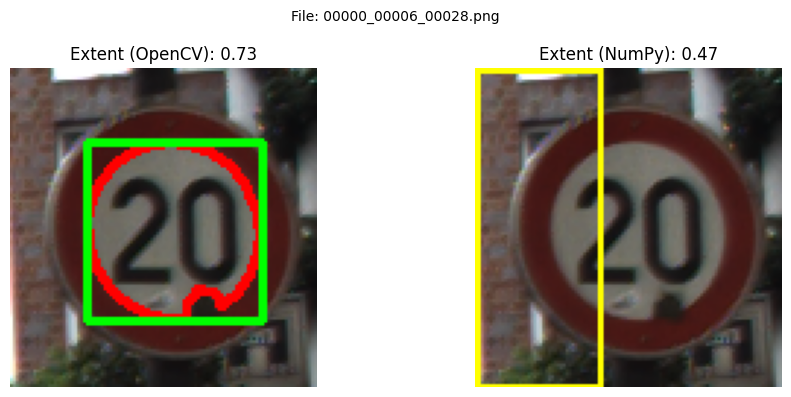

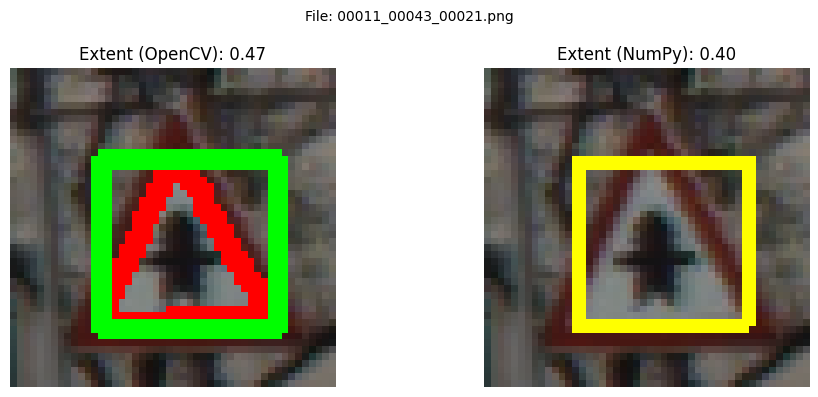

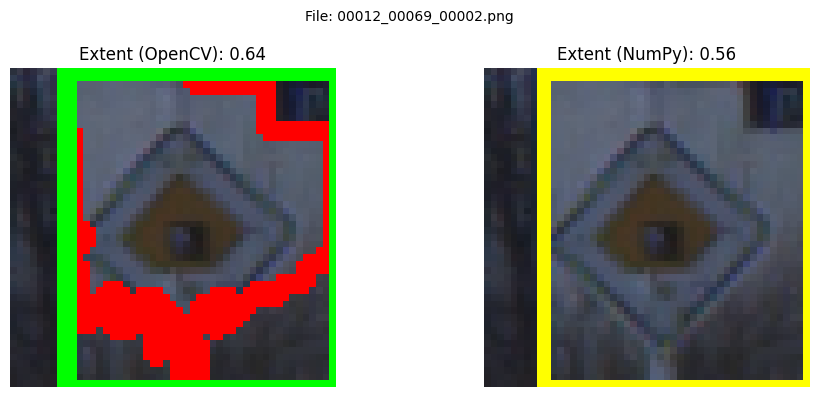

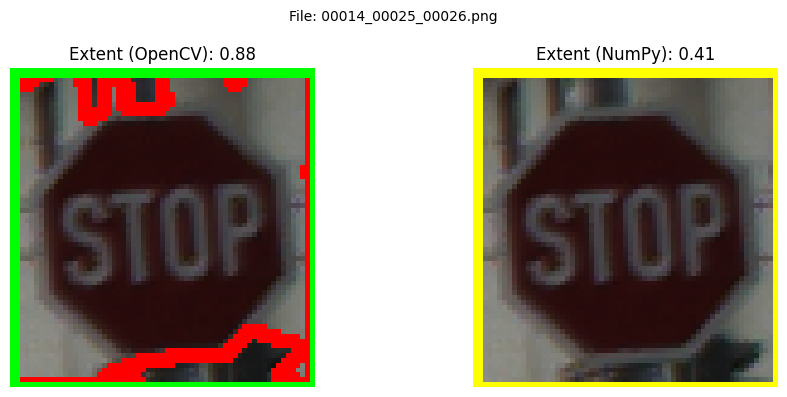

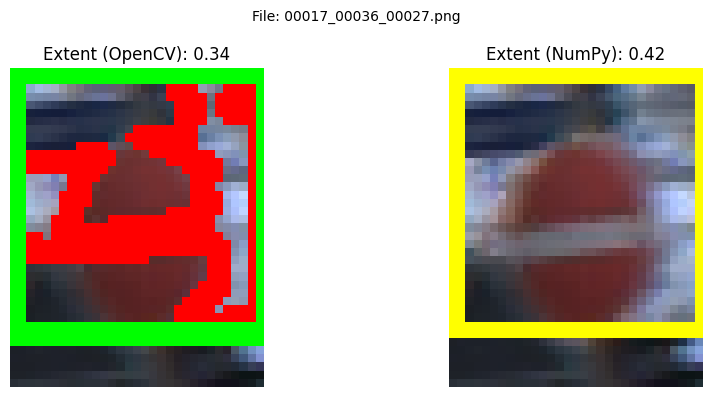

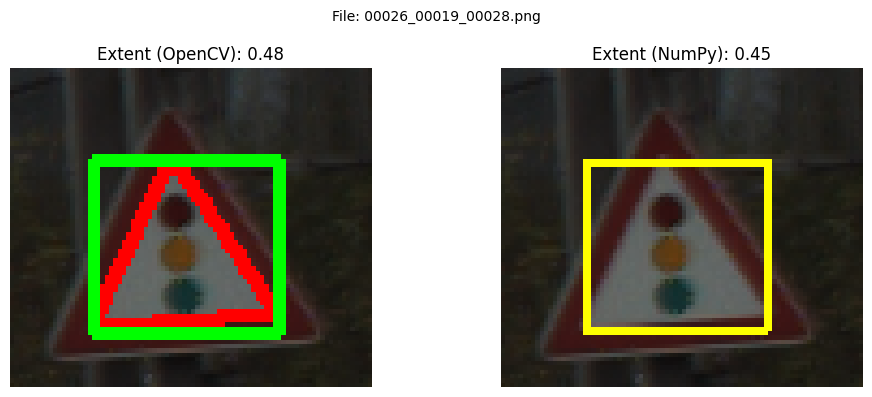

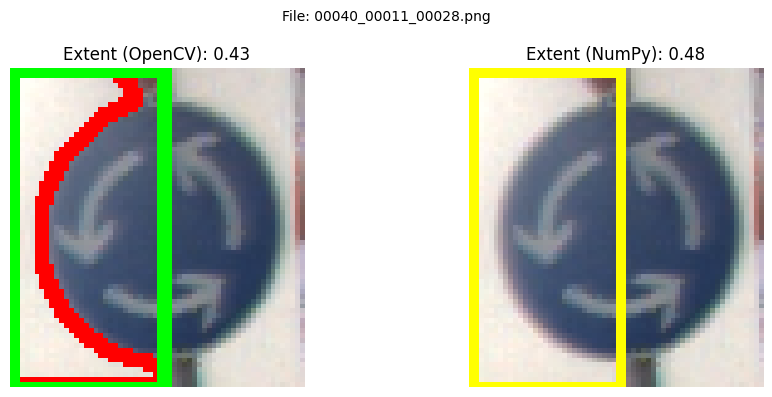

In [76]:
from collections import deque
def extent_cv2(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0.0
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    bbox_area = w * h
    extent = area / bbox_area if bbox_area != 0 else 0.0
    # draw for visualization
    vis = image.copy()
    cv2.drawContours(vis, [cnt], -1, (255, 0, 0), 2)
    cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return extent, vis


def  keep_largest_component(binary_mask): #this was added to make it better
    """
    Keeps only the largest connected component in a binary mask using pure NumPy.
    Uses BFS for connected component labeling.

    Parameters:
        binary_mask (np.ndarray): Binary mask (values 0 or 255).

    Returns:
        np.ndarray: Binary mask with only the largest component kept.
    """
    binary_mask = binary_mask.copy()
    visited = np.zeros_like(binary_mask, dtype=bool)
    h, w = binary_mask.shape
    label_id = 1
    label_map = np.zeros_like(binary_mask, dtype=np.int32)
    component_sizes = {}

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # 4-connected

    for y in range(h):
        for x in range(w):
            if binary_mask[y, x] > 0 and not visited[y, x]:
                # Start BFS
                queue = deque([(y, x)])
                visited[y, x] = True
                label_map[y, x] = label_id
                size = 1

                while queue:
                    cy, cx = queue.popleft()
                    for dy, dx in directions:
                        ny, nx = cy + dy, cx + dx
                        if 0 <= ny < h and 0 <= nx < w:
                            if binary_mask[ny, nx] > 0 and not visited[ny, nx]:
                                visited[ny, nx] = True
                                label_map[ny, nx] = label_id
                                queue.append((ny, nx))
                                size += 1

                component_sizes[label_id] = size
                label_id += 1

    if not component_sizes:
        return np.zeros_like(binary_mask, dtype=np.uint8)

    # Find label with max size
    largest_label = max(component_sizes, key=component_sizes.get)

    # Build new mask with only largest component
    output_mask = (label_map == largest_label).astype(np.uint8) * 255
    return output_mask

def extent(image):
    """
    Calculates extent using only NumPy (and cv2.cvtColor + cv2.threshold).
    Extent = Foreground Area / Bounding Box Area
    """
    # Convert to grayscale and apply Otsu's threshold
    gray = gray_scale_img(image)
    gray = np.uint8(gray)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # function to detect largest object and ignore noise
    binary = keep_largest_component(binary)

    # Convert to boolean mask
    binary_mask = binary > 0
    # Get coordinates of the foreground (white) pixels
    coords = np.argwhere(binary_mask)
    if coords.size == 0:
        return 0.0, image

    # Bounding box limits
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Area calculations
    bbox_area = (x_max - x_min + 1) * (y_max - y_min + 1)
    object_area = np.sum(binary_mask)

    extent_val = object_area / bbox_area if bbox_area != 0 else 0.0

    # Draw rectangle using NumPy
    vis = image.copy()
    vis[y_min:y_min+2, x_min:x_max+1] = [255, 255, 0]  # Top edge
    vis[y_max:y_max+2, x_min:x_max+1] = [255, 255, 0]  # Bottom edge
    vis[y_min:y_max+1, x_min:x_min+2] = [255, 255, 0]  # Left edge
    vis[y_min:y_max+1, x_max:x_max+2] = [255, 255, 0]  # Right edge

    return extent_val, vis

# === MAIN FUNCTION TO CALL ===
def process_and_display_extent_for_all(image_paths):
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        extent1, vis_cv2 = extent_cv2(img_rgb)
        extent2, vis_np = extent(img_rgb)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(vis_cv2)
        plt.title(f"Extent (OpenCV): {extent1:.2f}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(vis_np)
        plt.title(f"Extent (NumPy): {extent2:.2f}")
        plt.axis('off')

        plt.suptitle(f"File: {os.path.basename(img_path)}", fontsize=10)
        plt.tight_layout()
        plt.show()

process_and_display_extent_for_all(imgs)

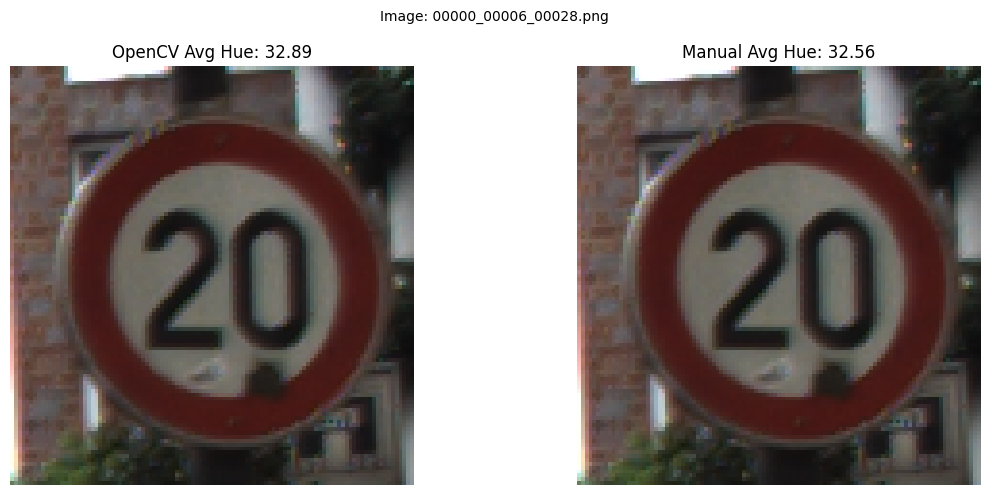

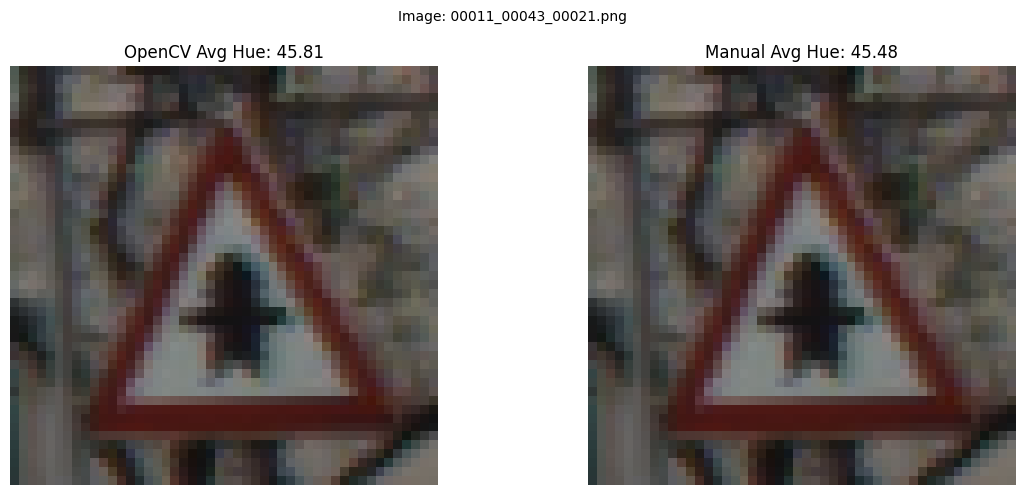

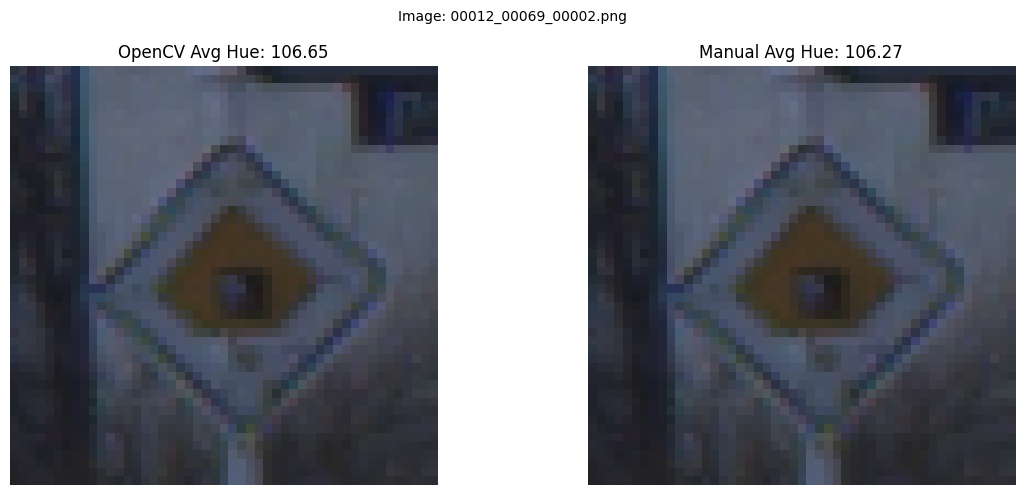

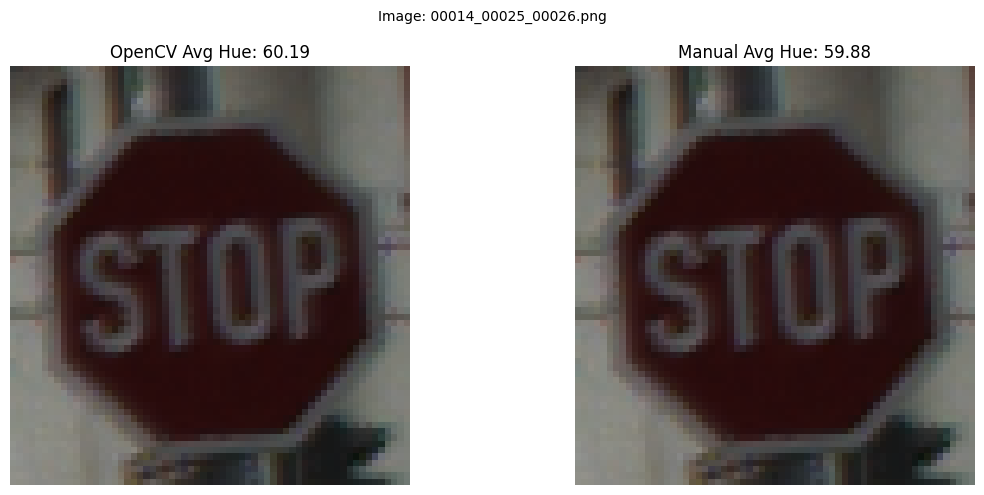

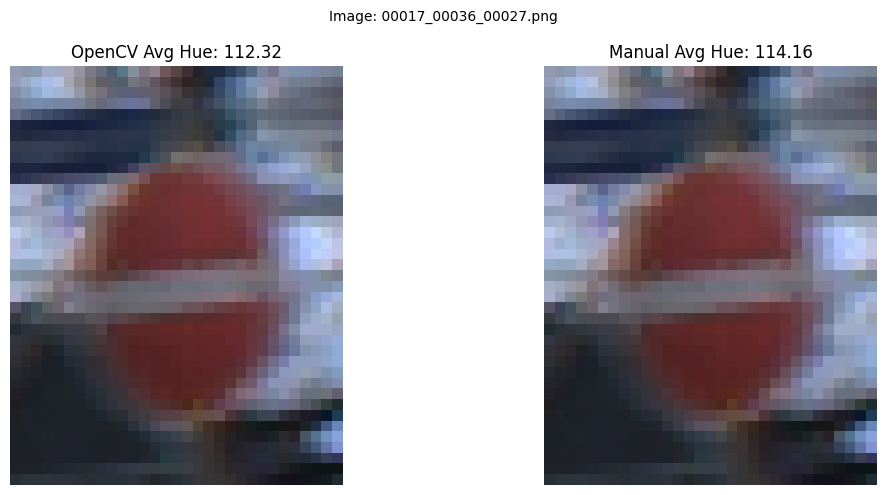

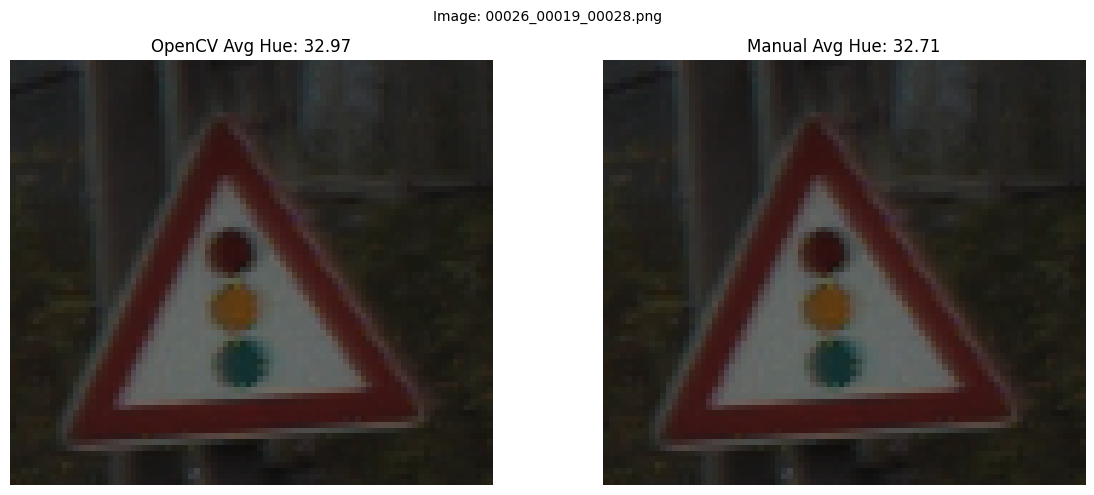

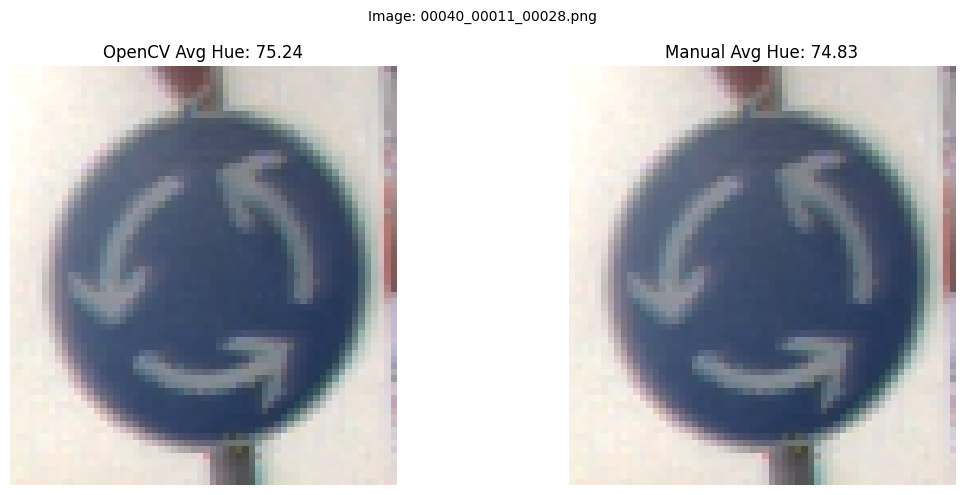

In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Manual RGB to HSV conversion with OpenCV-compatible scaling
def rgb_to_hsv_cv(img_rgb):
    img_rgb = img_rgb.astype('float32') / 255.0
    r, g, b = img_rgb[..., 0], img_rgb[..., 1], img_rgb[..., 2]
    cmax = np.max(img_rgb, axis=2)
    cmin = np.min(img_rgb, axis=2)
    delta = cmax - cmin

    h = np.zeros_like(cmax)
    mask = delta != 0

    idx = (cmax == r) & mask
    h[idx] = (60 * ((g[idx] - b[idx]) / delta[idx]) + 360) % 360

    idx = (cmax == g) & mask
    h[idx] = (60 * ((b[idx] - r[idx]) / delta[idx]) + 120) % 360

    idx = (cmax == b) & mask
    h[idx] = (60 * ((r[idx] - g[idx]) / delta[idx]) + 240) % 360

    h = h / 2  # Scale to [0, 180] like OpenCV
    s = np.where(cmax == 0, 0, (delta / cmax) * 255)
    v = cmax * 255

    hsv = np.stack([h, s, v], axis=-1).astype('uint8')
    return hsv

# Main display function
def process_and_display_avg_hue_comparison(image_paths):
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # OpenCV HSV and hue
        img_hsv_cv2 = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        average_hue_cv2 = np.mean(img_hsv_cv2[:, :, 0])

        # Manual HSV and hue
        img_hsv_manual = rgb_to_hsv_cv(img_rgb)
        average_hue_manual = np.mean(img_hsv_manual[:, :, 0])

        # Display
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title(f"OpenCV Avg Hue: {average_hue_cv2:.2f}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img_rgb)
        plt.title(f"Manual Avg Hue: {average_hue_manual:.2f}")
        plt.axis("off")

        plt.suptitle(f"Image: {os.path.basename(img_path)}", fontsize=10)
        plt.tight_layout()
        plt.show()

process_and_display_avg_hue_comparison(imgs)


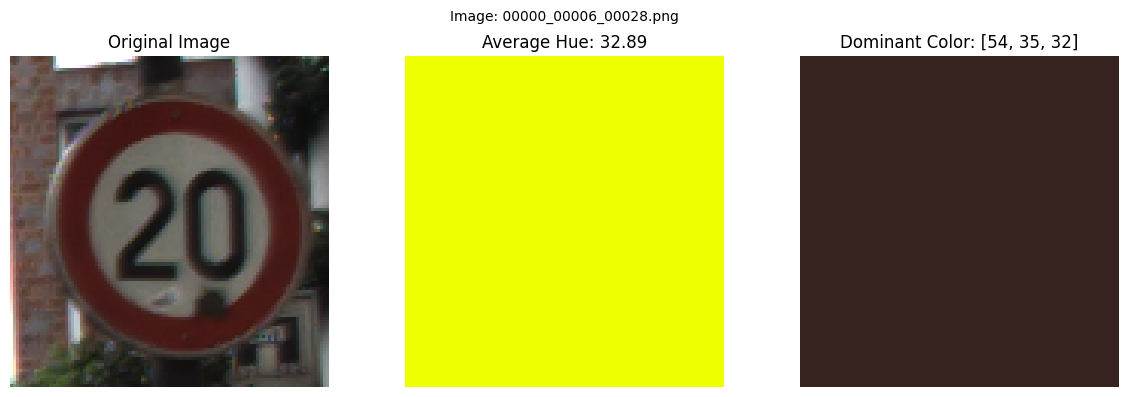

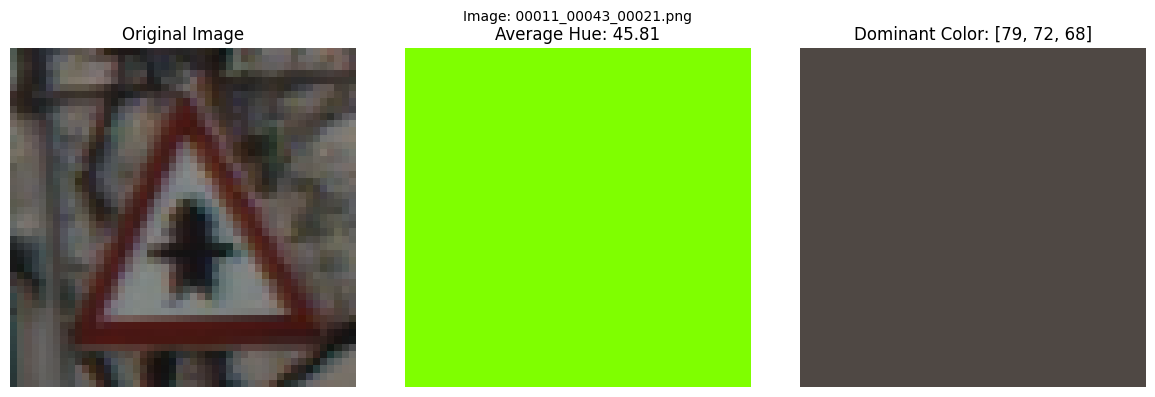

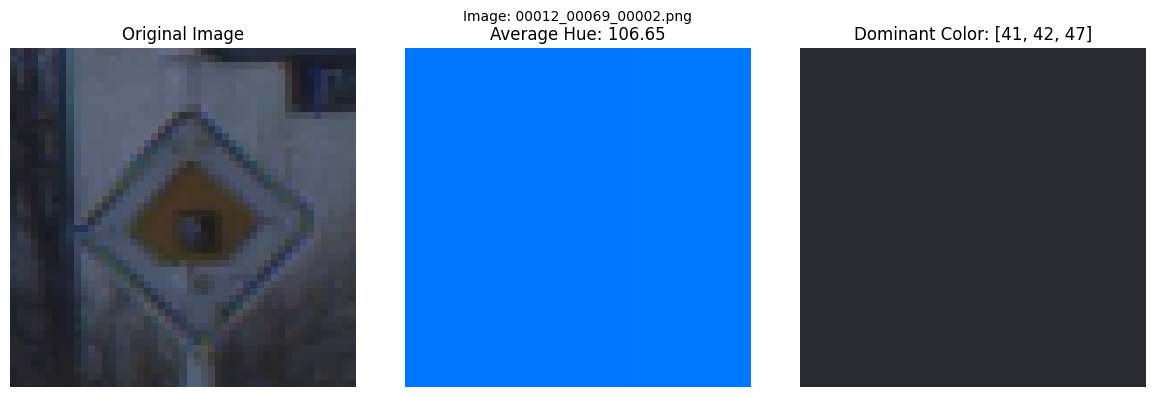

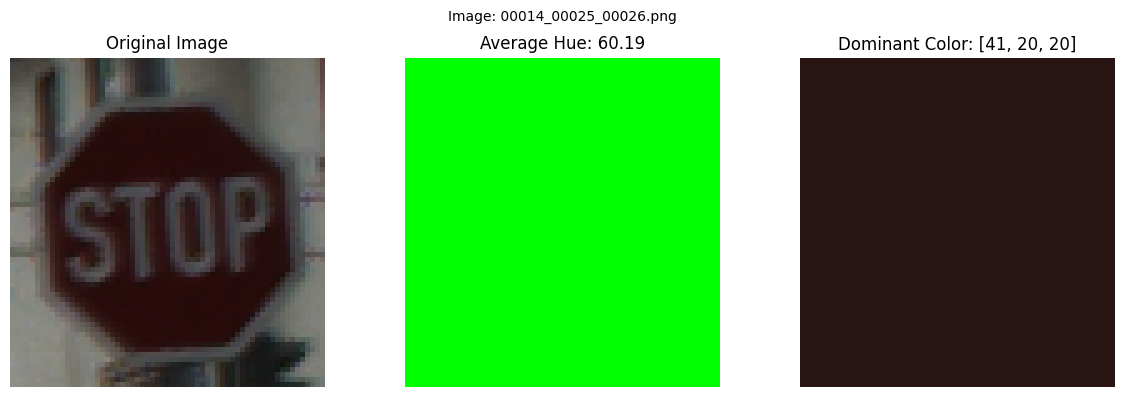

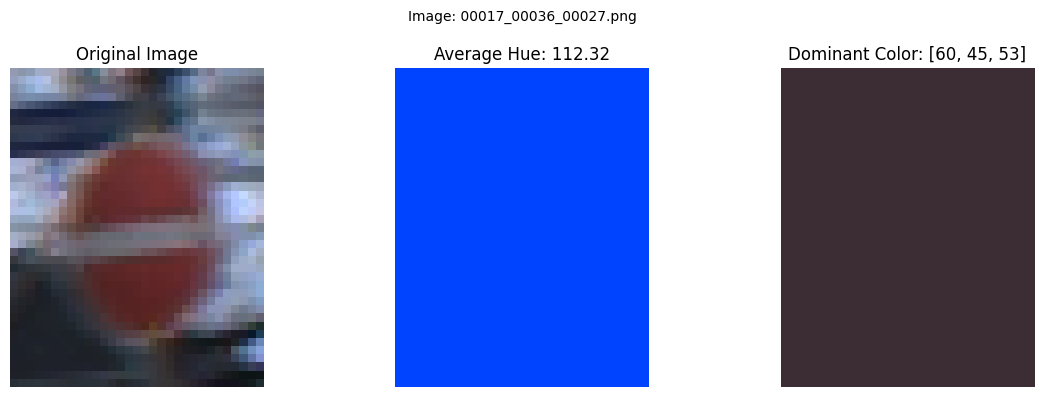

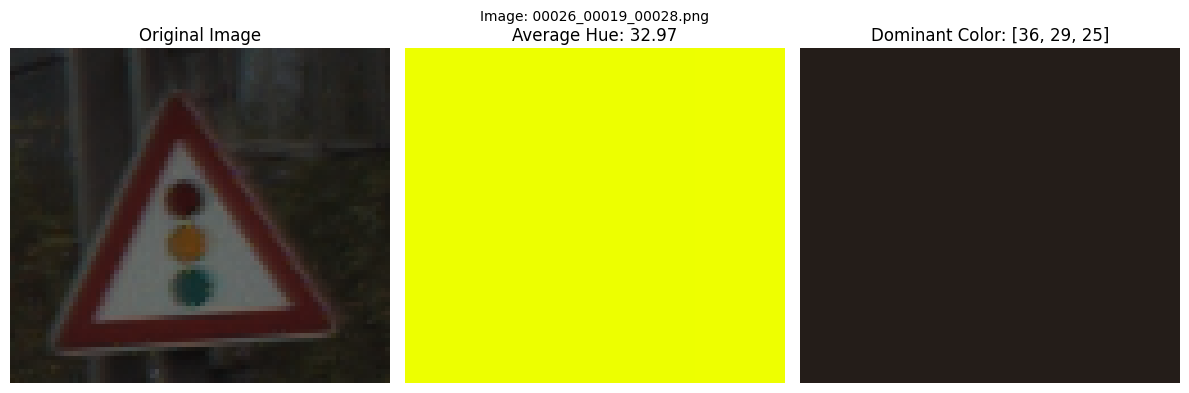

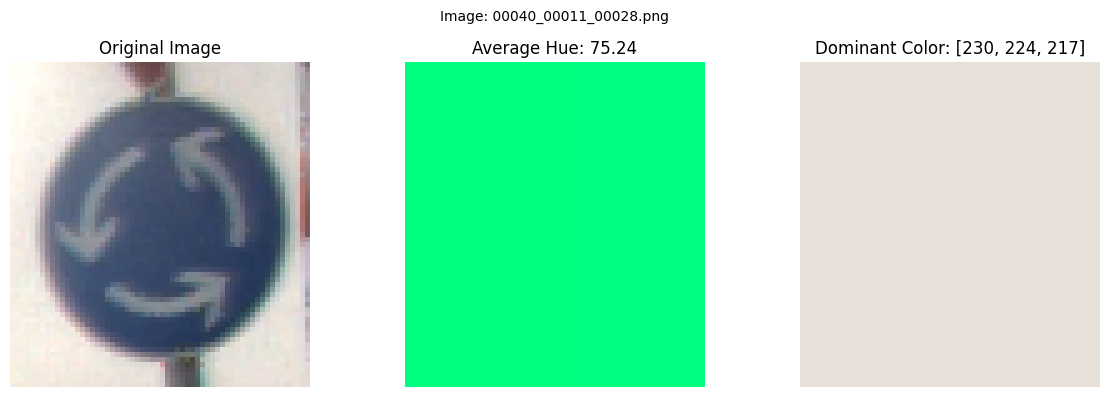

In [78]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def average_hue(image_rgb):
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    hue_channel = hsv[:, :, 0]
    avg_hue = np.mean(hue_channel)
    return avg_hue

def dominant_color_kmeans(image_rgb, k=3):
    pixels = image_rgb.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pixels)
    counts = np.bincount(kmeans.labels_)
    dominant_color = kmeans.cluster_centers_[np.argmax(counts)]
    return dominant_color.astype(int)

def process_and_display_color_features(image_paths, k=3):
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Extract features
        avg_hue_val = average_hue(img_rgb)
        dominant_color_val = dominant_color_kmeans(img_rgb, k=k)

        # Visualization
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title("Original Image")
        plt.axis('off')

        # Average Hue Visualization
        hue_img = cv2.cvtColor(np.zeros_like(img_rgb), cv2.COLOR_RGB2HSV)
        hue_img[:, :, 0] = avg_hue_val
        hue_img[:, :, 1] = 255
        hue_img[:, :, 2] = 255
        hue_rgb = cv2.cvtColor(hue_img, cv2.COLOR_HSV2RGB)
        plt.subplot(1, 3, 2)
        plt.imshow(hue_rgb)
        plt.title(f"Average Hue: {avg_hue_val:.2f}")
        plt.axis('off')

        # Dominant Color Visualization
        dom_color_img = np.full_like(img_rgb, dominant_color_val)
        plt.subplot(1, 3, 3)
        plt.imshow(dom_color_img)
        plt.title(f"Dominant Color: {dominant_color_val.tolist()}")
        plt.axis('off')

        plt.suptitle(f"Image: {os.path.basename(image_path)}", fontsize=10)
        plt.tight_layout()
        plt.show()

process_and_display_color_features(imgs)


Corner Count: 766
Circularity: 0.80
Aspect Ratio: 0.92
Extent: 0.72
Average Hue: 44.72


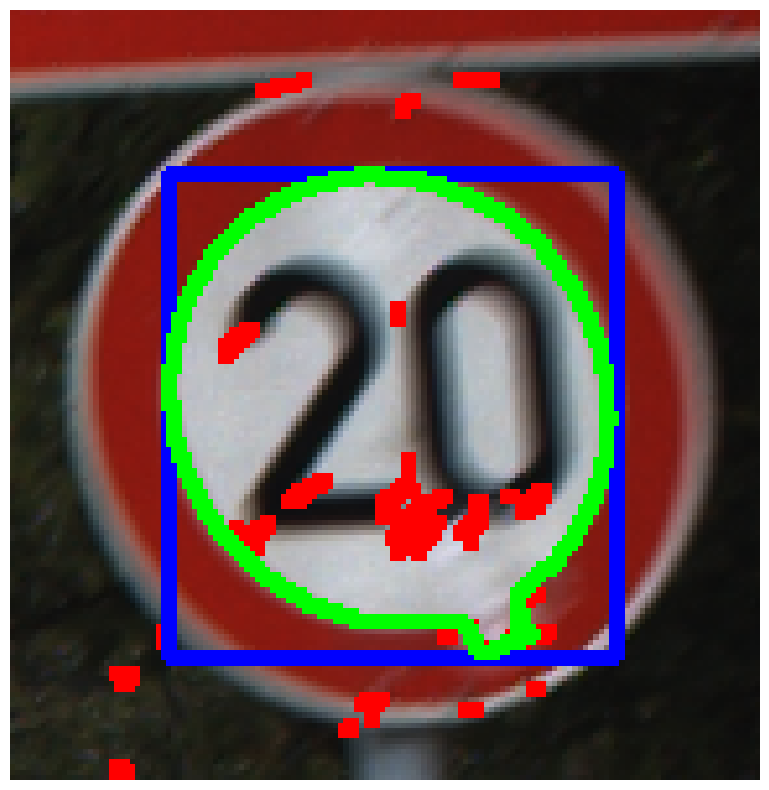

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for corner count using Harris Corner Detection
def corner_count(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    corners = dst > 0.01 * dst.max()
    corner_count = np.sum(corners)
    return corners

# Function to calculate circularity
def circularity(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    circularity_value = (4 * np.pi * area) / (perimeter ** 2)
    return circularity_value

# Function to calculate aspect ratio
def aspect_ratio(bbox):
    width, height = bbox[2], bbox[3]
    return width / height

# Function to calculate extent
def extent(contour, image_shape):
    x, y, w, h = cv2.boundingRect(contour)
    bbox_area = w * h
    area = cv2.contourArea(contour)
    extent_value = area / bbox_area if bbox_area != 0 else 0
    return extent_value

# Function to calculate average hue
def average_hue(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    avg_hue = np.mean(hsv[:, :, 0])  # Hue channel
    return avg_hue

# Function to visualize features without clutter
def visualize_features(image, corners, largest_contour, bbox):
    # Create a copy of the image for visualization
    image_copy = image.copy()

    # Mark corners (red points)
    image_copy[corners] = [255, 0, 0]

    # Draw bounding box (blue rectangle)
    x, y, w, h = bbox
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Draw contour (green line)
    cv2.drawContours(image_copy, [largest_contour], -1, (0, 255, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_copy)
    plt.axis('off')
    plt.show()

# Load image (you can replace this with your own image)
image = cv2.imread('/content/drive/MyDrive/traffic_dataset_subset/train/0/00000_00000_00029.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Find contours for calculating circularity, extent
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the sign
largest_contour = max(contours, key=cv2.contourArea)

# Extract features
corners = corner_count(image_rgb)
circularity_value = circularity(largest_contour)
bbox = cv2.boundingRect(largest_contour)
aspect_ratio_value = aspect_ratio(bbox)
extent_value = extent(largest_contour, image_rgb.shape)
avg_hue_value = average_hue(image_rgb)

# Print extracted features
print(f"Corner Count: {np.sum(corners)}")
print(f"Circularity: {circularity_value:.2f}")
print(f"Aspect Ratio: {aspect_ratio_value:.2f}")
print(f"Extent: {extent_value:.2f}")
print(f"Average Hue: {avg_hue_value:.2f}")

# Visualize the features on the image
visualize_features(image_rgb, corners, largest_contour, bbox)


# IGNORE THIS STUFF


In [ ]:
import os
import zipfile
import pandas as pd
import random
import shutil

#step 1: Unzip Dataset
def unzip_dataset(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Dataset extracted to {extract_to}")

#step 2: Create Subset
def create_subset(original_root_dir, original_csv_path, new_root_dir, selected_classes, images_per_class):
    os.makedirs(os.path.join(new_root_dir, 'train'), exist_ok=True)
    train_df = pd.read_csv(original_csv_path)

    new_entries = []

    #copying 'test' folder and 'test.csv'
    test_dir = os.path.join(original_root_dir, '../test')
    test_csv = os.path.join(original_root_dir, '../Test.csv')

    #copy 'test' folder to new root directory
    if os.path.exists(test_dir):
        shutil.copytree(test_dir, os.path.join(new_root_dir, 'test'))
        print("Test folder copied successfully.")

    #copy 'test.csv' to new root directory
    if os.path.exists(test_csv):
        shutil.copy(test_csv, os.path.join(new_root_dir, 'test.csv'))
        print("Test.csv copied successfully.")

    #process the selected classes for the 'train' folder
    for class_id in selected_classes:
        #filter images of the selected class
        class_images = train_df[train_df['ClassId'] == class_id]

        if len(class_images) < images_per_class:
            print(f"Warning: Class {class_id} has only {len(class_images)} images available.")
            selected_images = class_images
        else:
            selected_images = class_images.sample(n=images_per_class, random_state=42)

        #create class folder in new dataset
        class_folder = os.path.join(new_root_dir, 'train', str(class_id))
        os.makedirs(class_folder, exist_ok=True)

        for _, row in selected_images.iterrows():
            #src_path
            relative_path = row['Path'].split('/', 1)[1]  # remove 'train/' prefix
            src_path = os.path.join(original_root_dir, relative_path)

            dst_path = os.path.join(class_folder, os.path.basename(row['Path']))

            #copying image
            shutil.copy(src_path, dst_path)

            #updatin relative path to new_root_dir
            new_entry = {
                'Path': os.path.relpath(dst_path, new_root_dir).replace("\\", "/"),
                'ClassId': class_id
            }
            new_entries.append(new_entry)

    new_train_df = pd.DataFrame(new_entries)
    new_train_df.to_csv(os.path.join(new_root_dir, 'train.csv'), index=False)
    print(f"Subset created with {len(new_entries)} images.")


# Paths
zip_path = '/content/drive/MyDrive/archive.zip'
extracted_folder = '/content/traffic_dataset'

# Unzip
unzip_dataset(zip_path, extracted_folder)

# Paths after extraction
original_root_dir = os.path.join(extracted_folder, 'train')
original_csv_path = os.path.join(extracted_folder, 'Train.csv')  # CSV might still be 'Train.csv'

# New dataset save path
new_root_dir = '/content/drive/MyDrive/traffic_dataset_subset'

# Selected Classes (based on proper mapping)
selected_classes = [0, 7, 14, 21, 28, 35, 42]
images_per_class = 100

# Create subset
create_subset(original_root_dir, original_csv_path, new_root_dir, selected_classes, images_per_class)

#step 3: Clean up extracted large dataset
# shutil.rmtree(extracted_folder)
# print("Deleted full extracted dataset to save memory.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/archive.zip'

In [ ]:
# After create_subset() is done
# Step 3: Clean up extracted large dataset
# shutil.rmtree(new_root_dir)
# print("Deleted full extracted dataset to save memory.")

# Step 4: Print the new train.csv
print("\n------ Contents of new train.csv ------")
new_train_csv_path = os.path.join(new_root_dir, 'train.csv')
new_train_df = pd.read_csv(new_train_csv_path)
print(new_train_df)

# Step 5: Print class distribution for train
print("\n------ Number of images per ClassId in Train ------")
class_counts_train = new_train_df['ClassId'].value_counts().sort_index()
for class_id, count in class_counts_train.items():
    print(f"Class {class_id}: {count} images")

# Step 6: Print new dataset directory structure for train (only folders and PNGs, no file names)
print("\n------ New Dataset Folder Structure for Train ------")
for root, dirs, files in os.walk(new_root_dir):
    level = root.replace(new_root_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    folder_name = os.path.basename(root)
    print(f"{indent}{folder_name}/")
    for d in dirs:
        print(f"{indent}    {d}/")
    # Just say 'PNGs' if png images are inside
    png_files = [f for f in files if f.lower().endswith('.png')]
    if png_files:
        print(f"{indent}    PNGs")

# Step 7: Print the new test.csv (if exists)
print("\n------ Contents of new test.csv ------")
test_csv_path = os.path.join(new_root_dir, 'test.csv')
if os.path.exists(test_csv_path):
    test_df = pd.read_csv(test_csv_path)
    print(test_df)
else:
    print("No test.csv file found.")

# Step 8: Print class distribution for test (if test.csv exists)
print("\n------ Number of images per ClassId in Test ------")
if os.path.exists(test_csv_path):
    class_counts_test = test_df['ClassId'].value_counts().sort_index()
    for class_id, count in class_counts_test.items():
        print(f"Class {class_id}: {count} images")
else:
    print("No class distribution found for test data.")

# Step 9: Print new dataset directory structure for test (only folders and PNGs, no file names)
print("\n------ New Dataset Folder Structure for Test ------")
test_dir_path = os.path.join(new_root_dir, 'test')
if os.path.exists(test_dir_path):
    for root, dirs, files in os.walk(test_dir_path):
        level = root.replace(test_dir_path, '').count(os.sep)
        indent = ' ' * 4 * level
        folder_name = os.path.basename(root)
        print(f"{indent}{folder_name}/")
        for d in dirs:
            print(f"{indent}    {d}/")
        # Just say 'PNGs' if png images are inside
        png_files = [f for f in files if f.lower().endswith('.png')]
        if png_files:
            print(f"{indent}    PNGs")
else:
    print("No 'test' folder found.")


In [ ]:
new_train_df